Analyze subject's unique hues and isoslant data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

from data_analysis.load_data import LoadData
from data_analysis.yml2dict import yml2dict

plt.style.use('data_analysis/figures/plot_style.txt')

rgbs = yml2dict('data_analysis/rgb4plot.yaml')
palette = {'red': rgbs[0], 'blue': rgbs[135], 'green': rgbs[220], 'yellow': rgbs[315]}



# Iso-slant Data

In [51]:
def plot_isoslant(subject, save_path='data_analysis/figures/isoslant'):
    """
    Plot isoslant fitting and save the figure.

    :param subject:         subject name, for example 's00'
    :param subject_path:    directory where the isoslant file ('colorspace_s00.json') is stored

    """
    file_name = f"config/subjects/colorspace/10bit/colorspace_{subject}.json"
    with open(file_name, "r") as f:
        iso_slant = json.loads(json.load(f)['iso_slant'])

    a = iso_slant['amplitude']
    ph = iso_slant['phase']
    off = iso_slant['offset']
    # xdata = np.array(iso_slant['xdata'])
    xdata = np.array(iso_slant['xdata']) / np.pi * 180
    ydata = np.array(iso_slant['ydata'])

    # x = np.arange(0., 2 * np.pi, 0.05 * np.pi)
    # yfit = a * np.sin(x + ph)

    x = np.arange(0., 360, .5)
    yfit = a * np.sin(x/180 * np.pi + ph) + off
    # fig, ax = plt.subplots()
    plt.scatter(xdata, ydata, marker= 'x', label='data', color='black')
    plt.plot(x, yfit, label='fit')
    # x_peak = x[np.argmax(f)]
    if a > 0:
        x_peak = np.pi * .5 - ph
    else:
        x_peak = np.pi * 1.5 - ph
        
    x_peak = x_peak/np.pi * 180
    plt.vlines(x_peak, np.min(ydata), np.max(ydata), linestyles='dashed', colors='gray')
    # plt.grid()
    plt.legend()
    # plt.xticks(np.arange(0., 2 * np.pi, 0.2 * np.pi))
    # plt.xticks(np.arange(0., 2 * np.pi, 0.2 * np.pi), labels=np.arange(0., 360, 36))
    # plt.xlabel('Hue Angle \u03B8 (rad)')
    plt.xticks(np.append(np.unique(xdata), 360))
    plt.xlabel('Hue Angle \u03B8 (deg)')
    plt.ylabel('Delta Luminance contrast')
    plt.xlim([-5, 360])
    plt.annotate(f"peak \u03B8 = {np.round(x_peak, 2)}", xy=(x_peak*0.8, np.max(ydata)*1.05))
    plt.title(f"{subject} \n"
              f"dLum = {np.round(a, 3)} sin(\u03B8 [rad] + {np.round(ph, 3)}) + {np.round(off, 3)}")
    plt.savefig(f"{save_path}/isoslant_{subject}.pdf")
    plt.show()


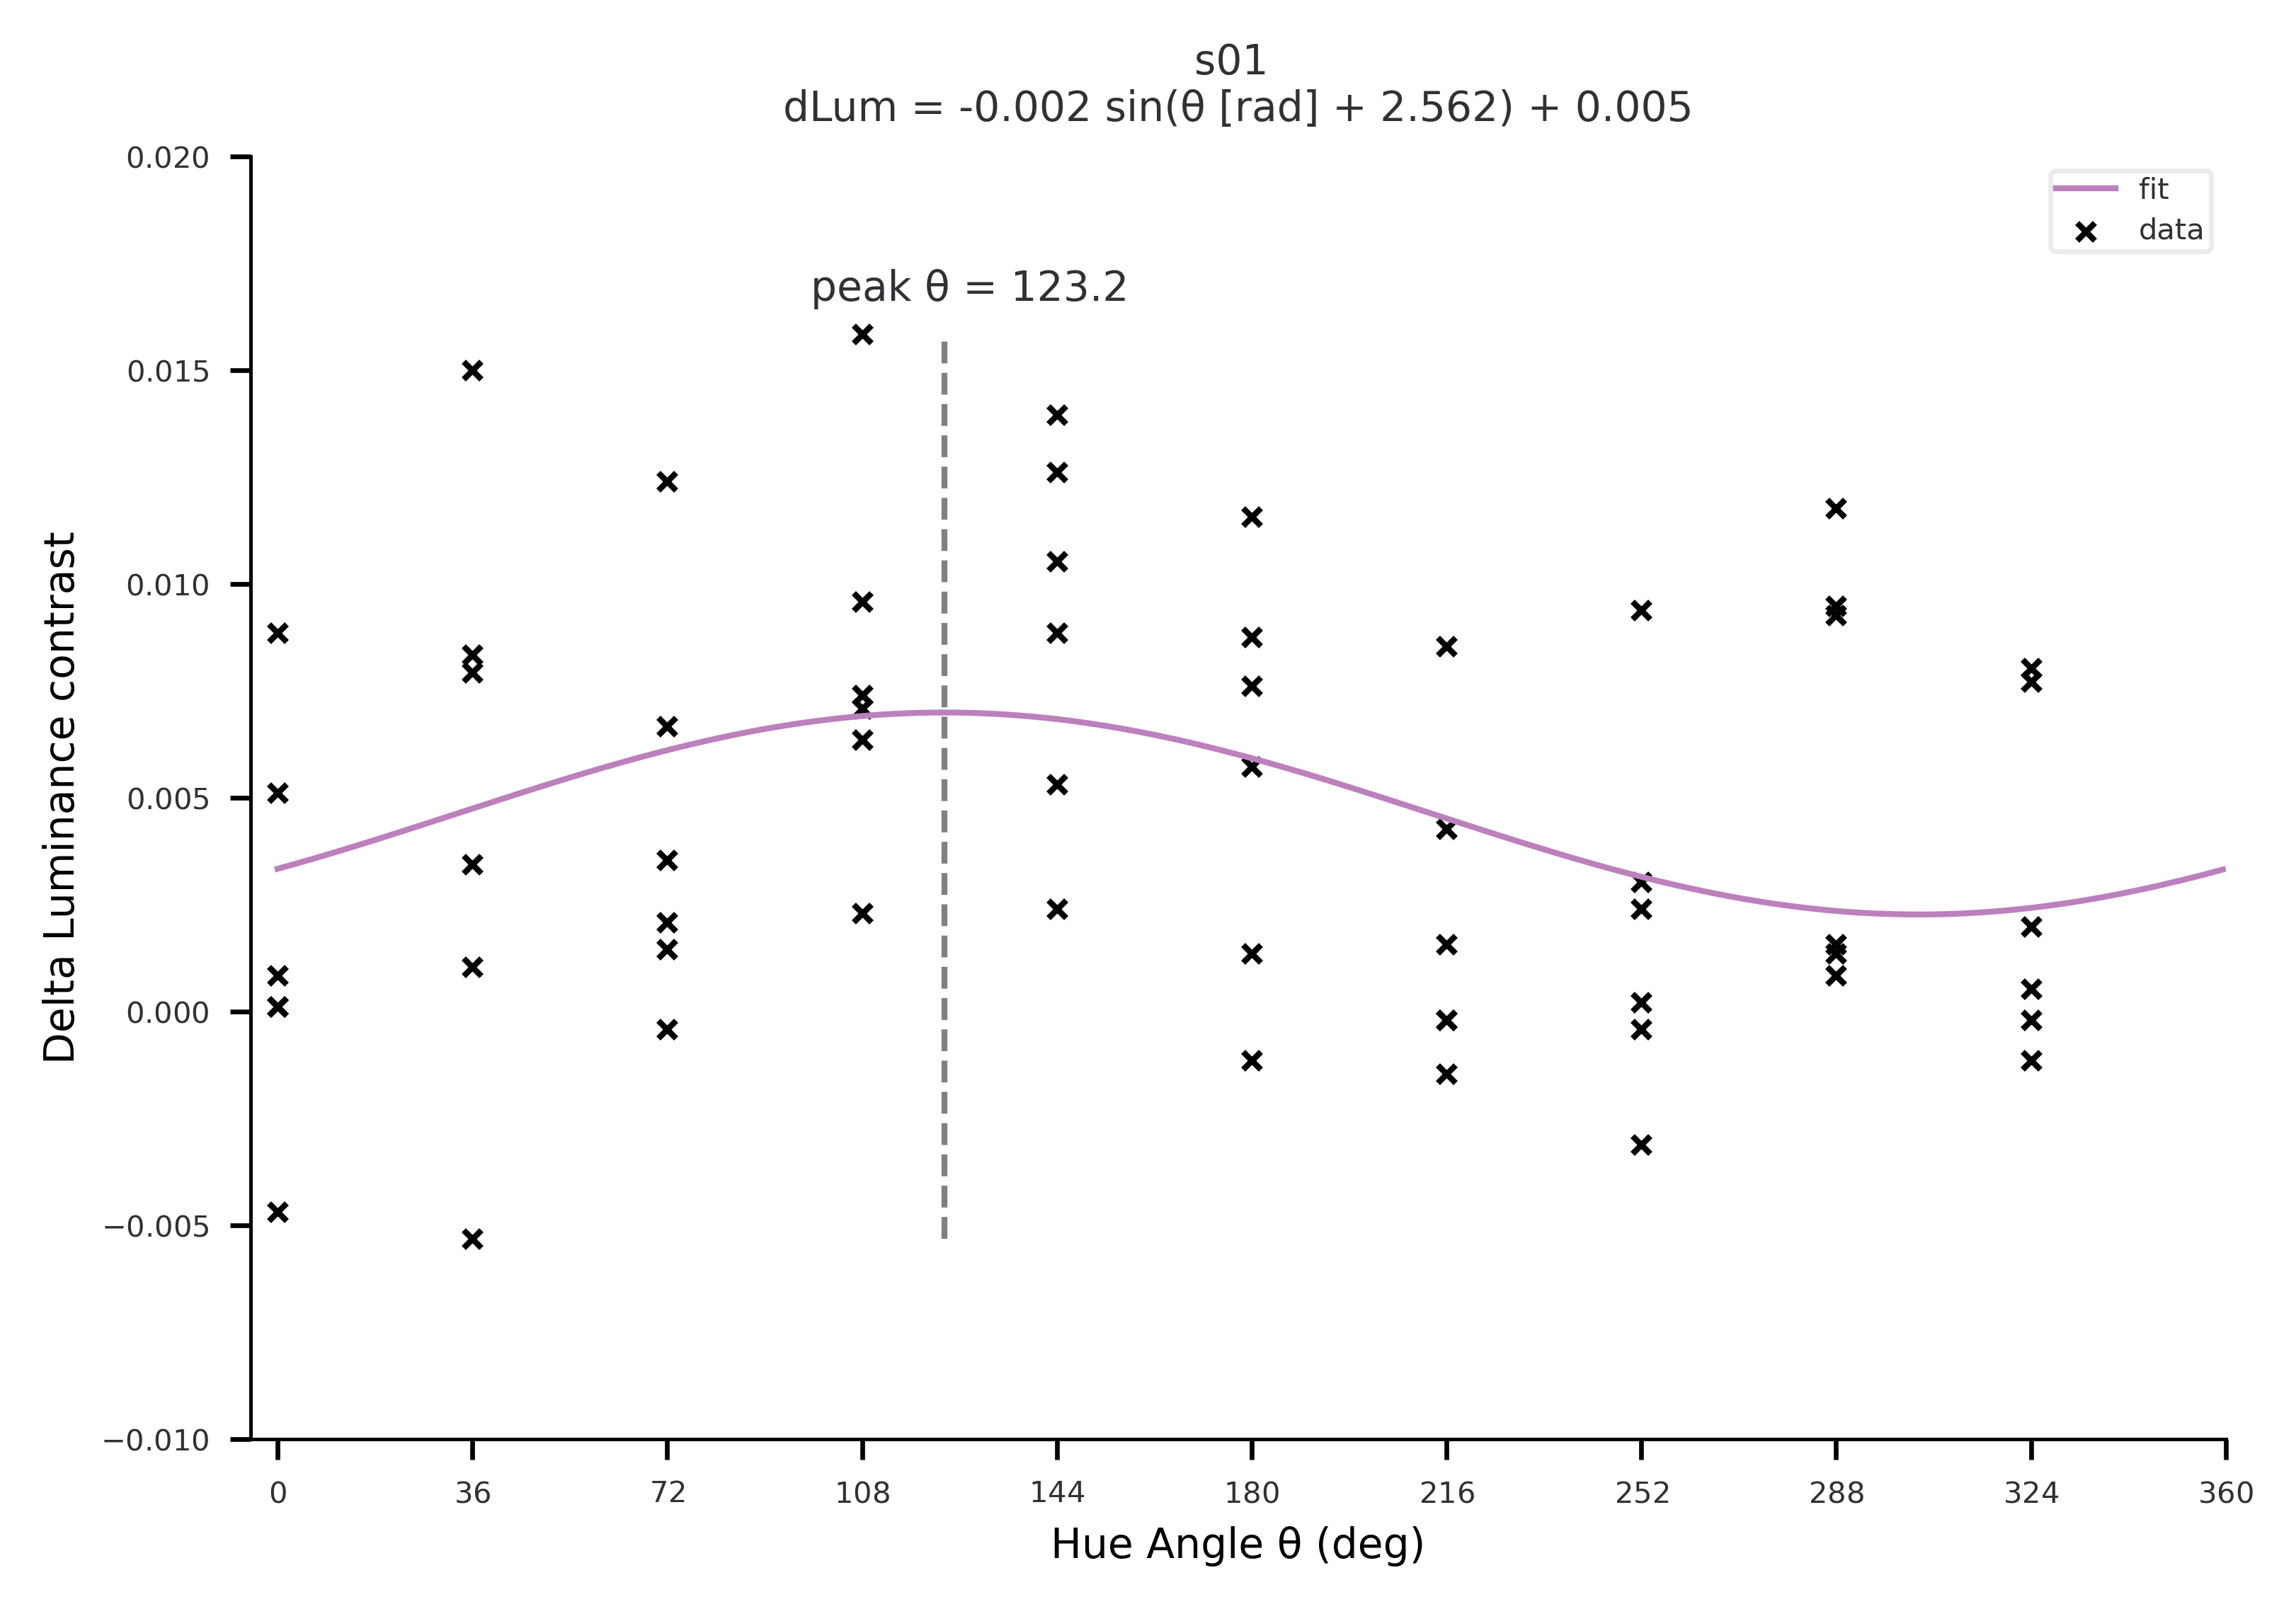

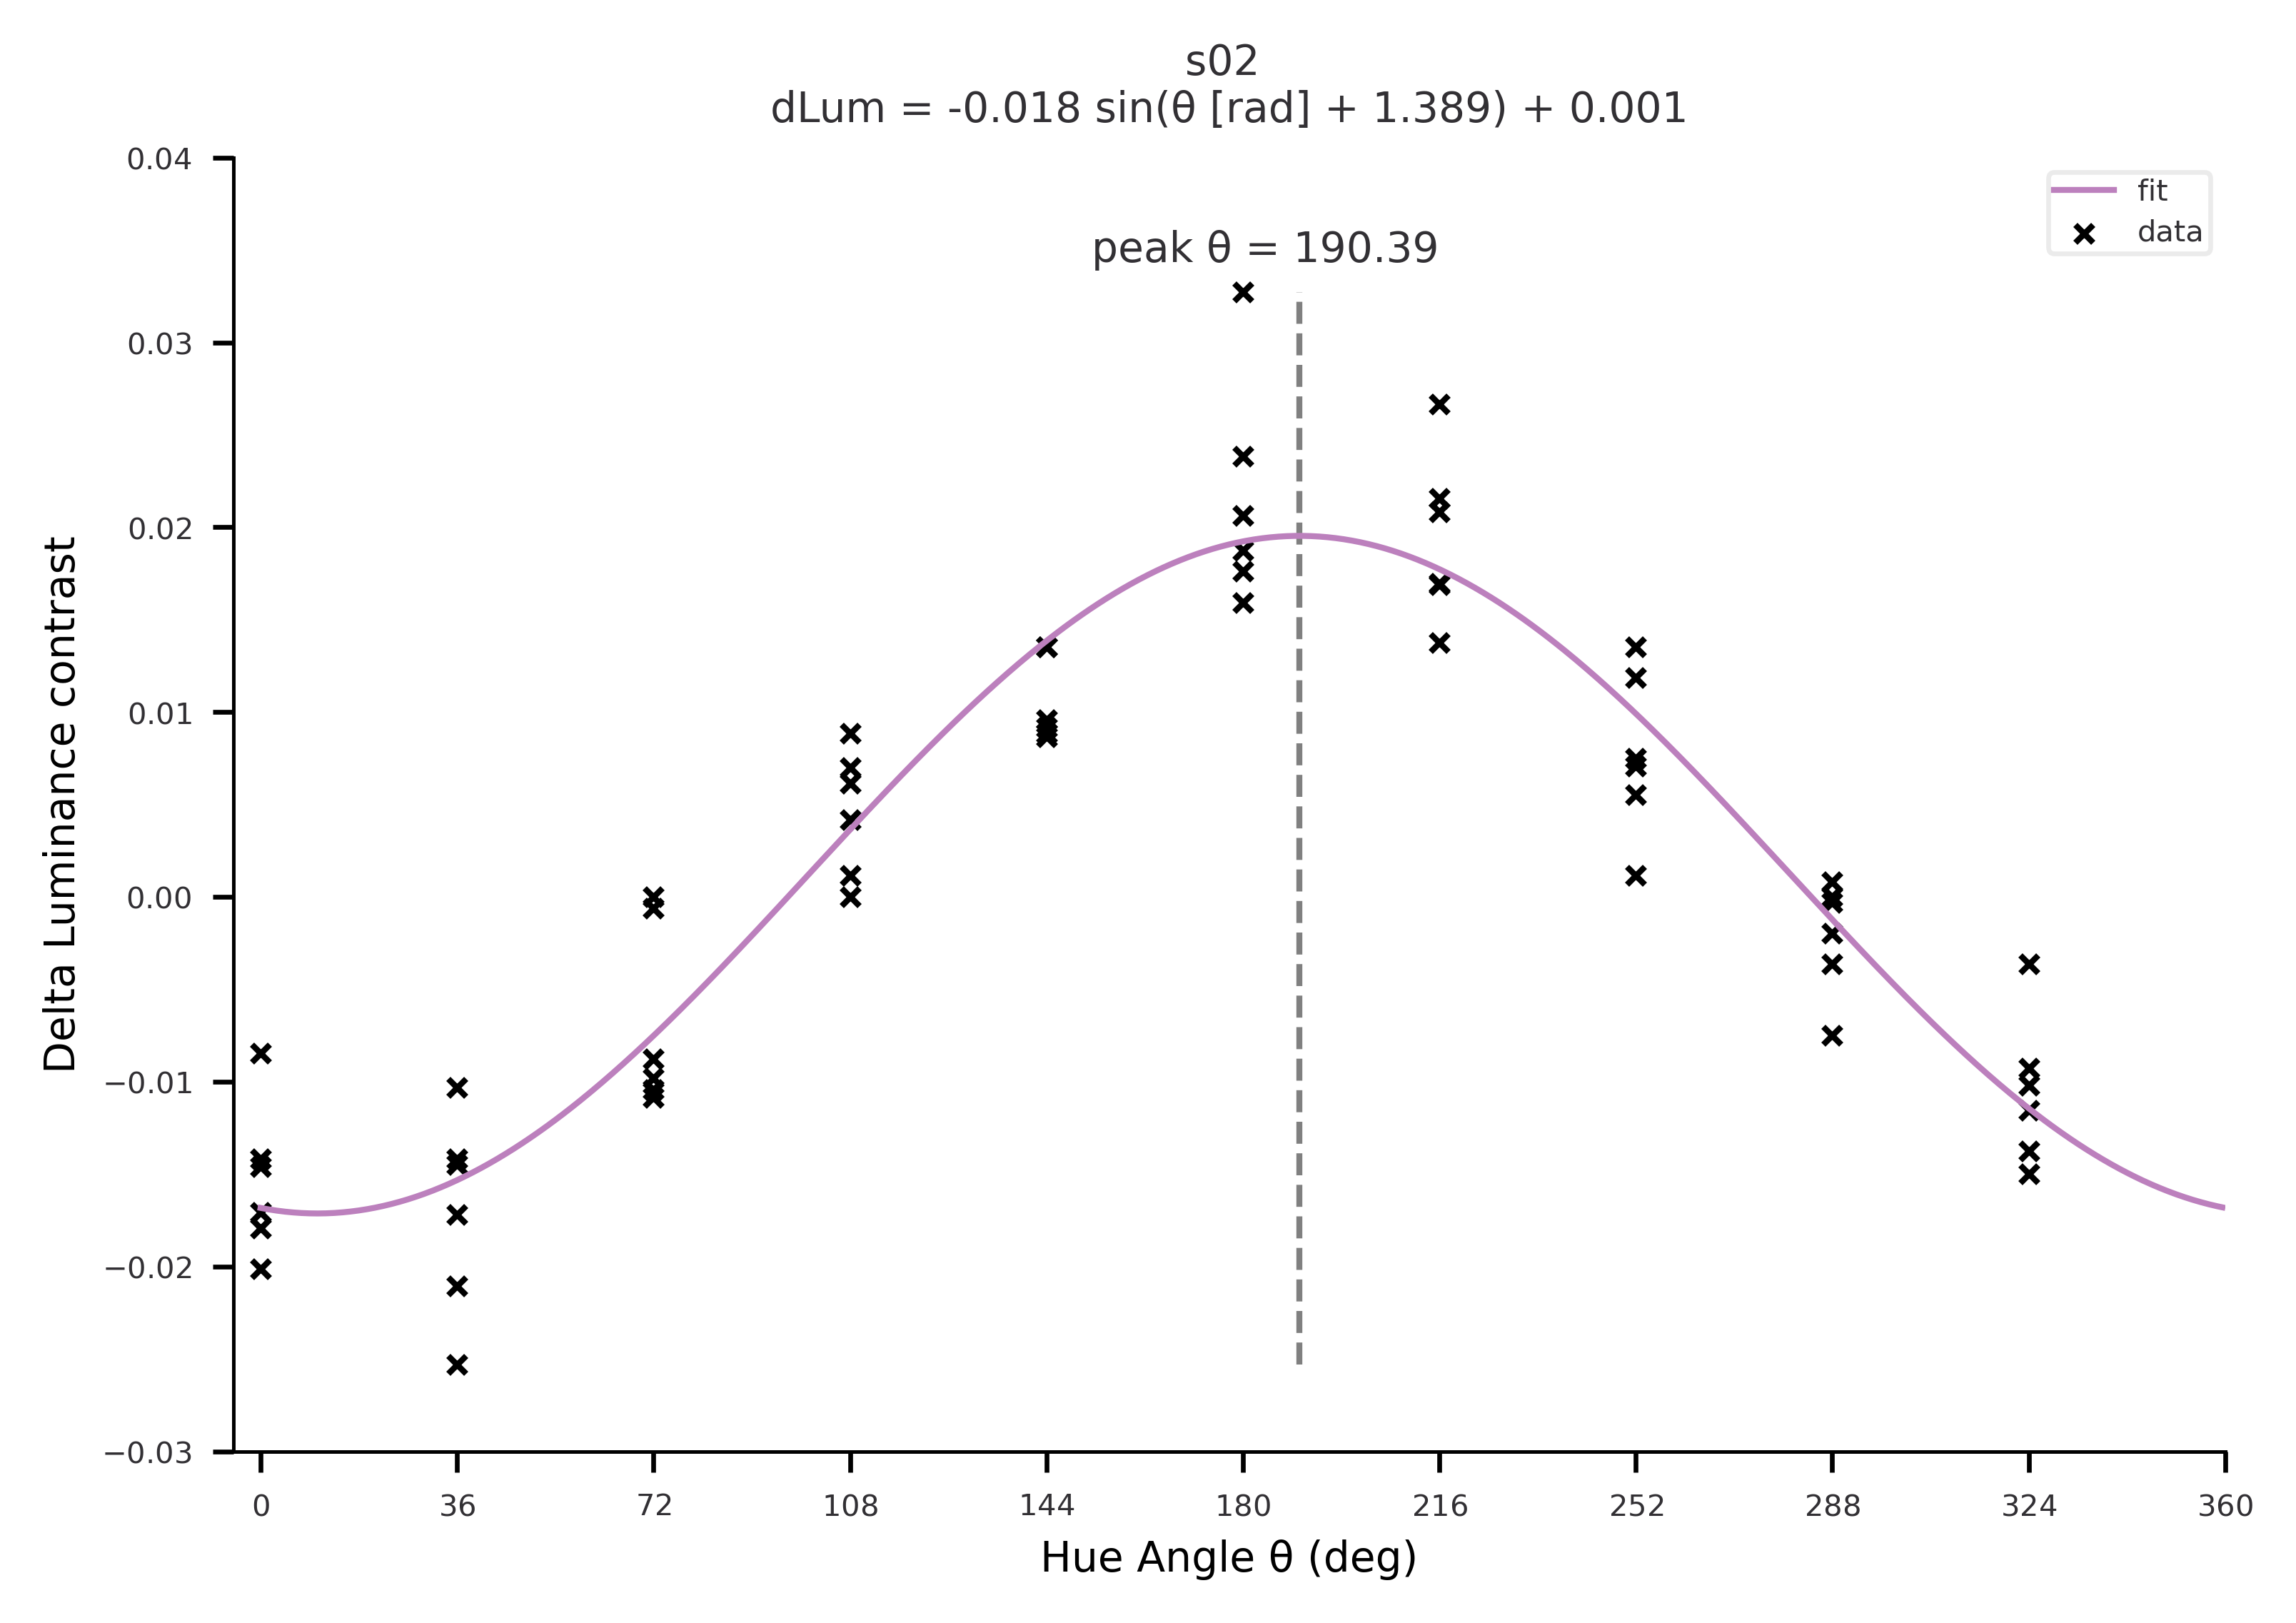

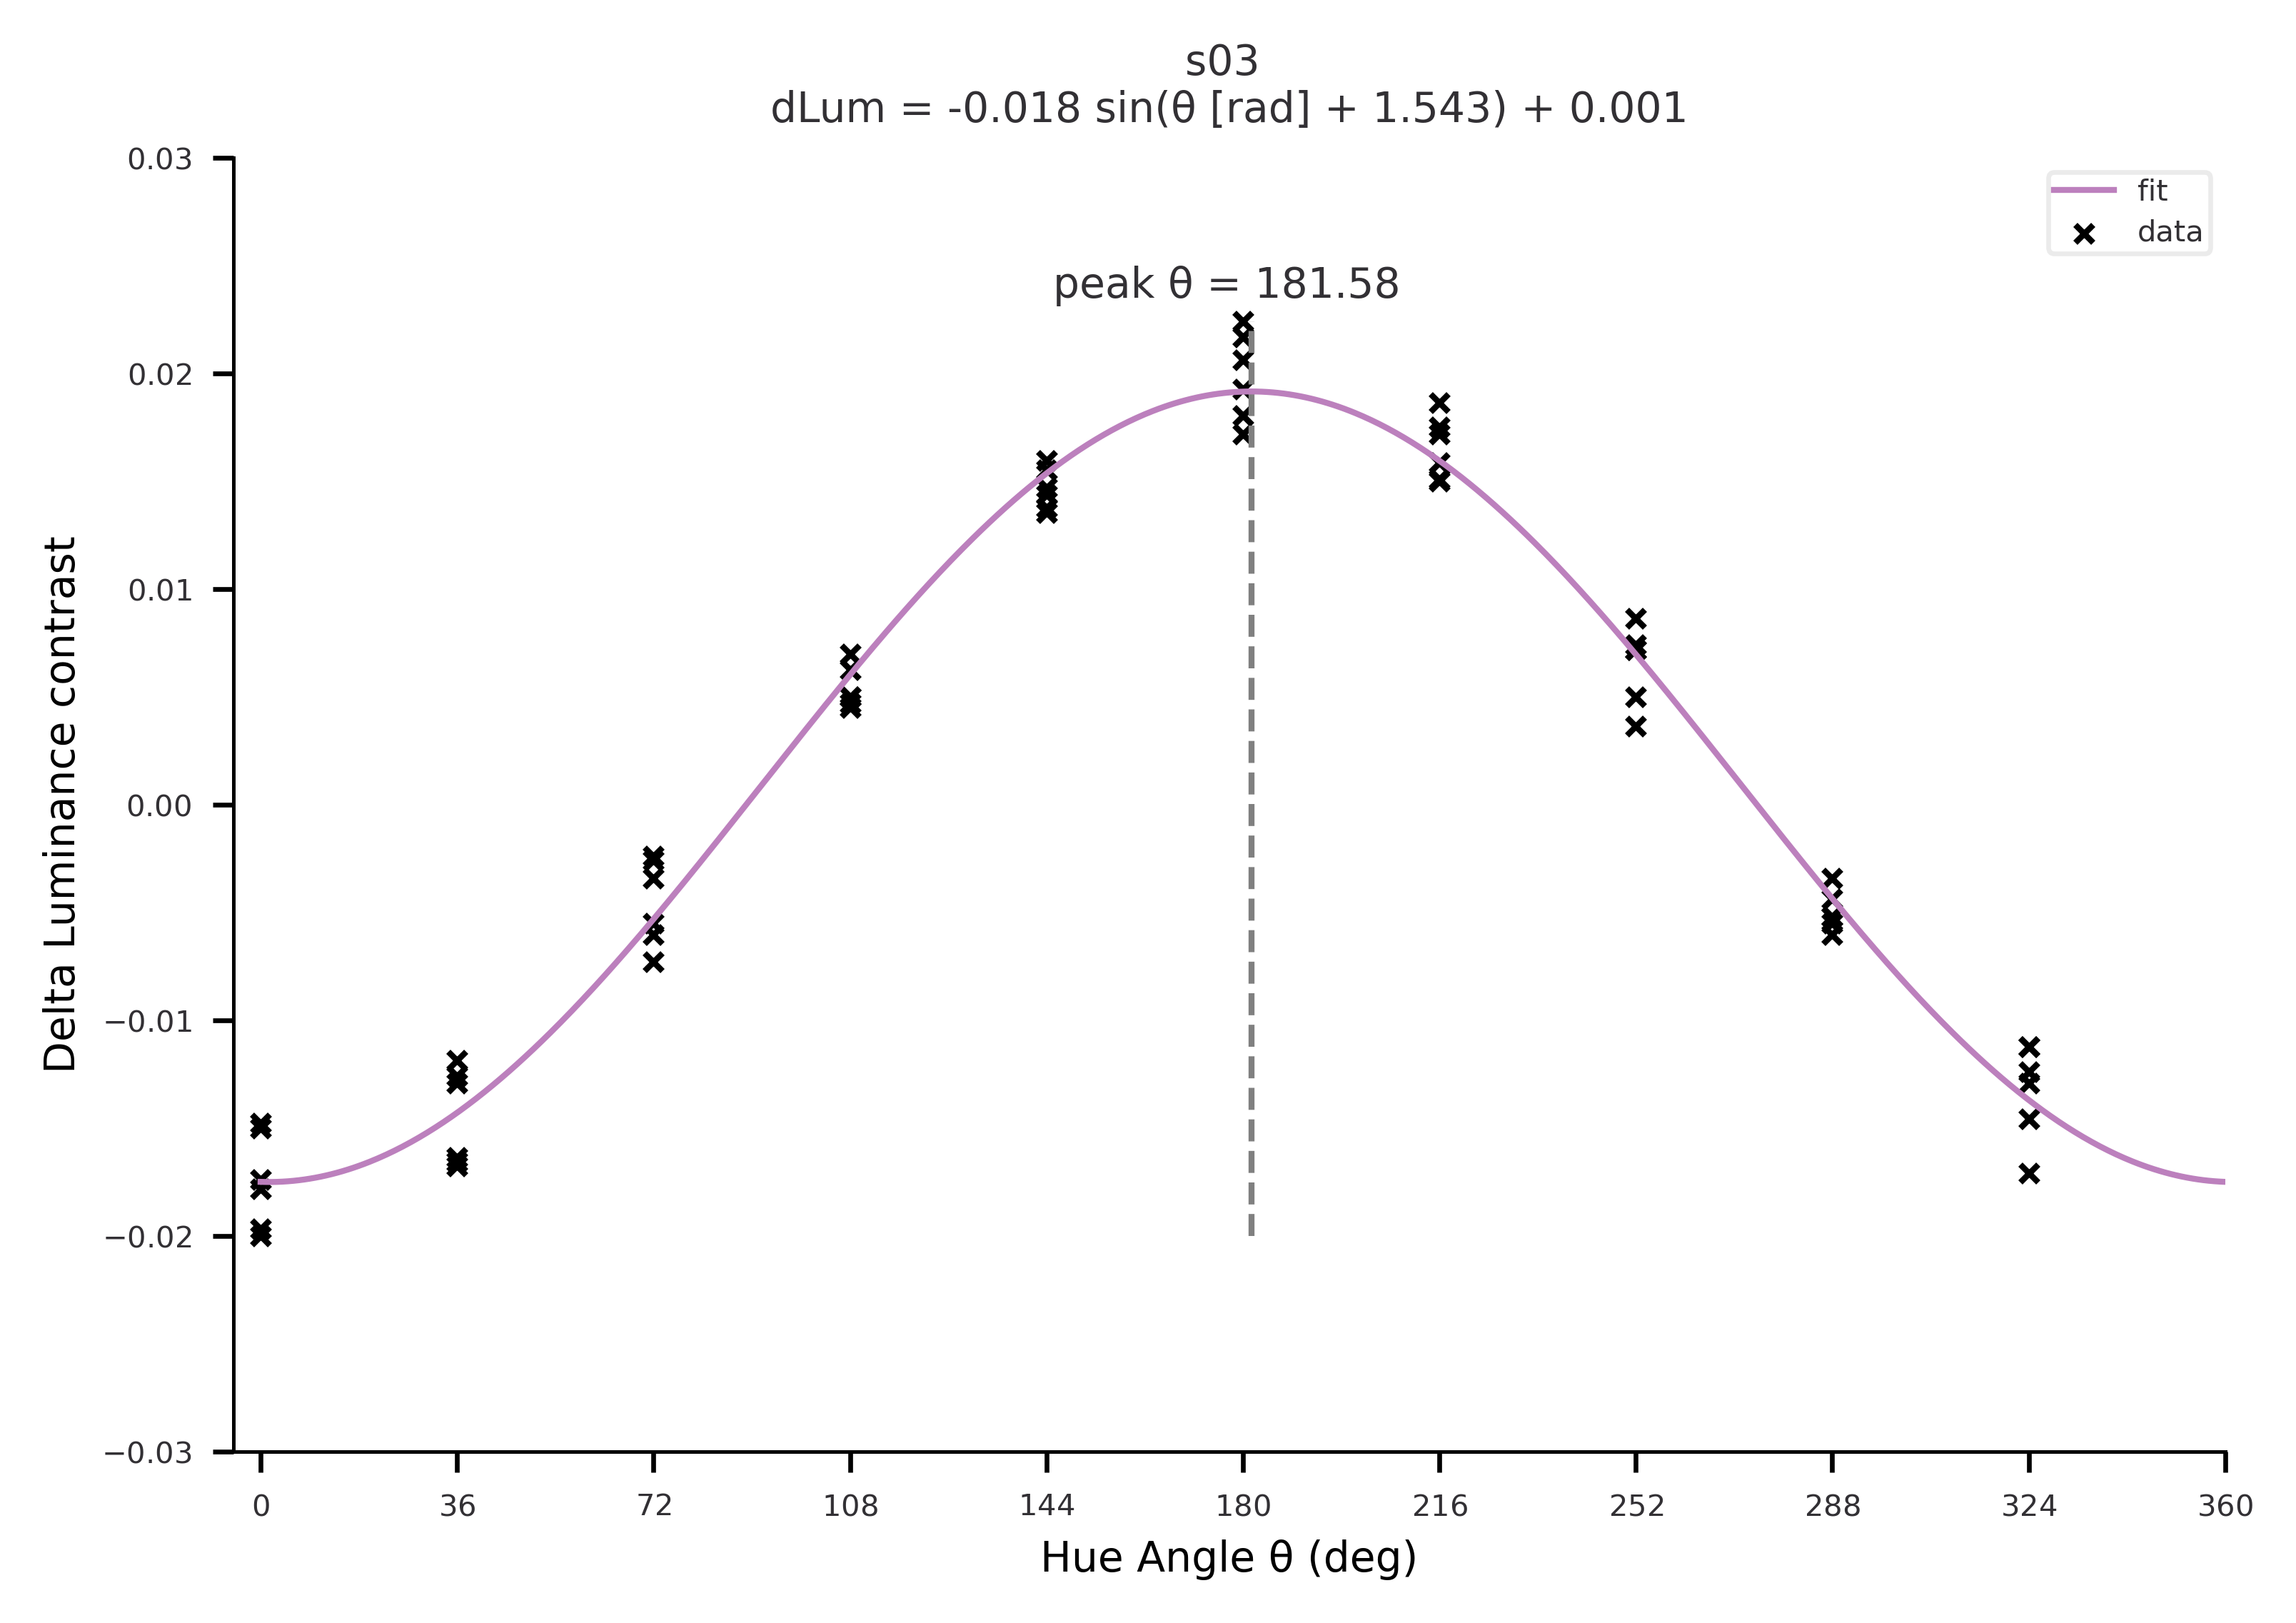

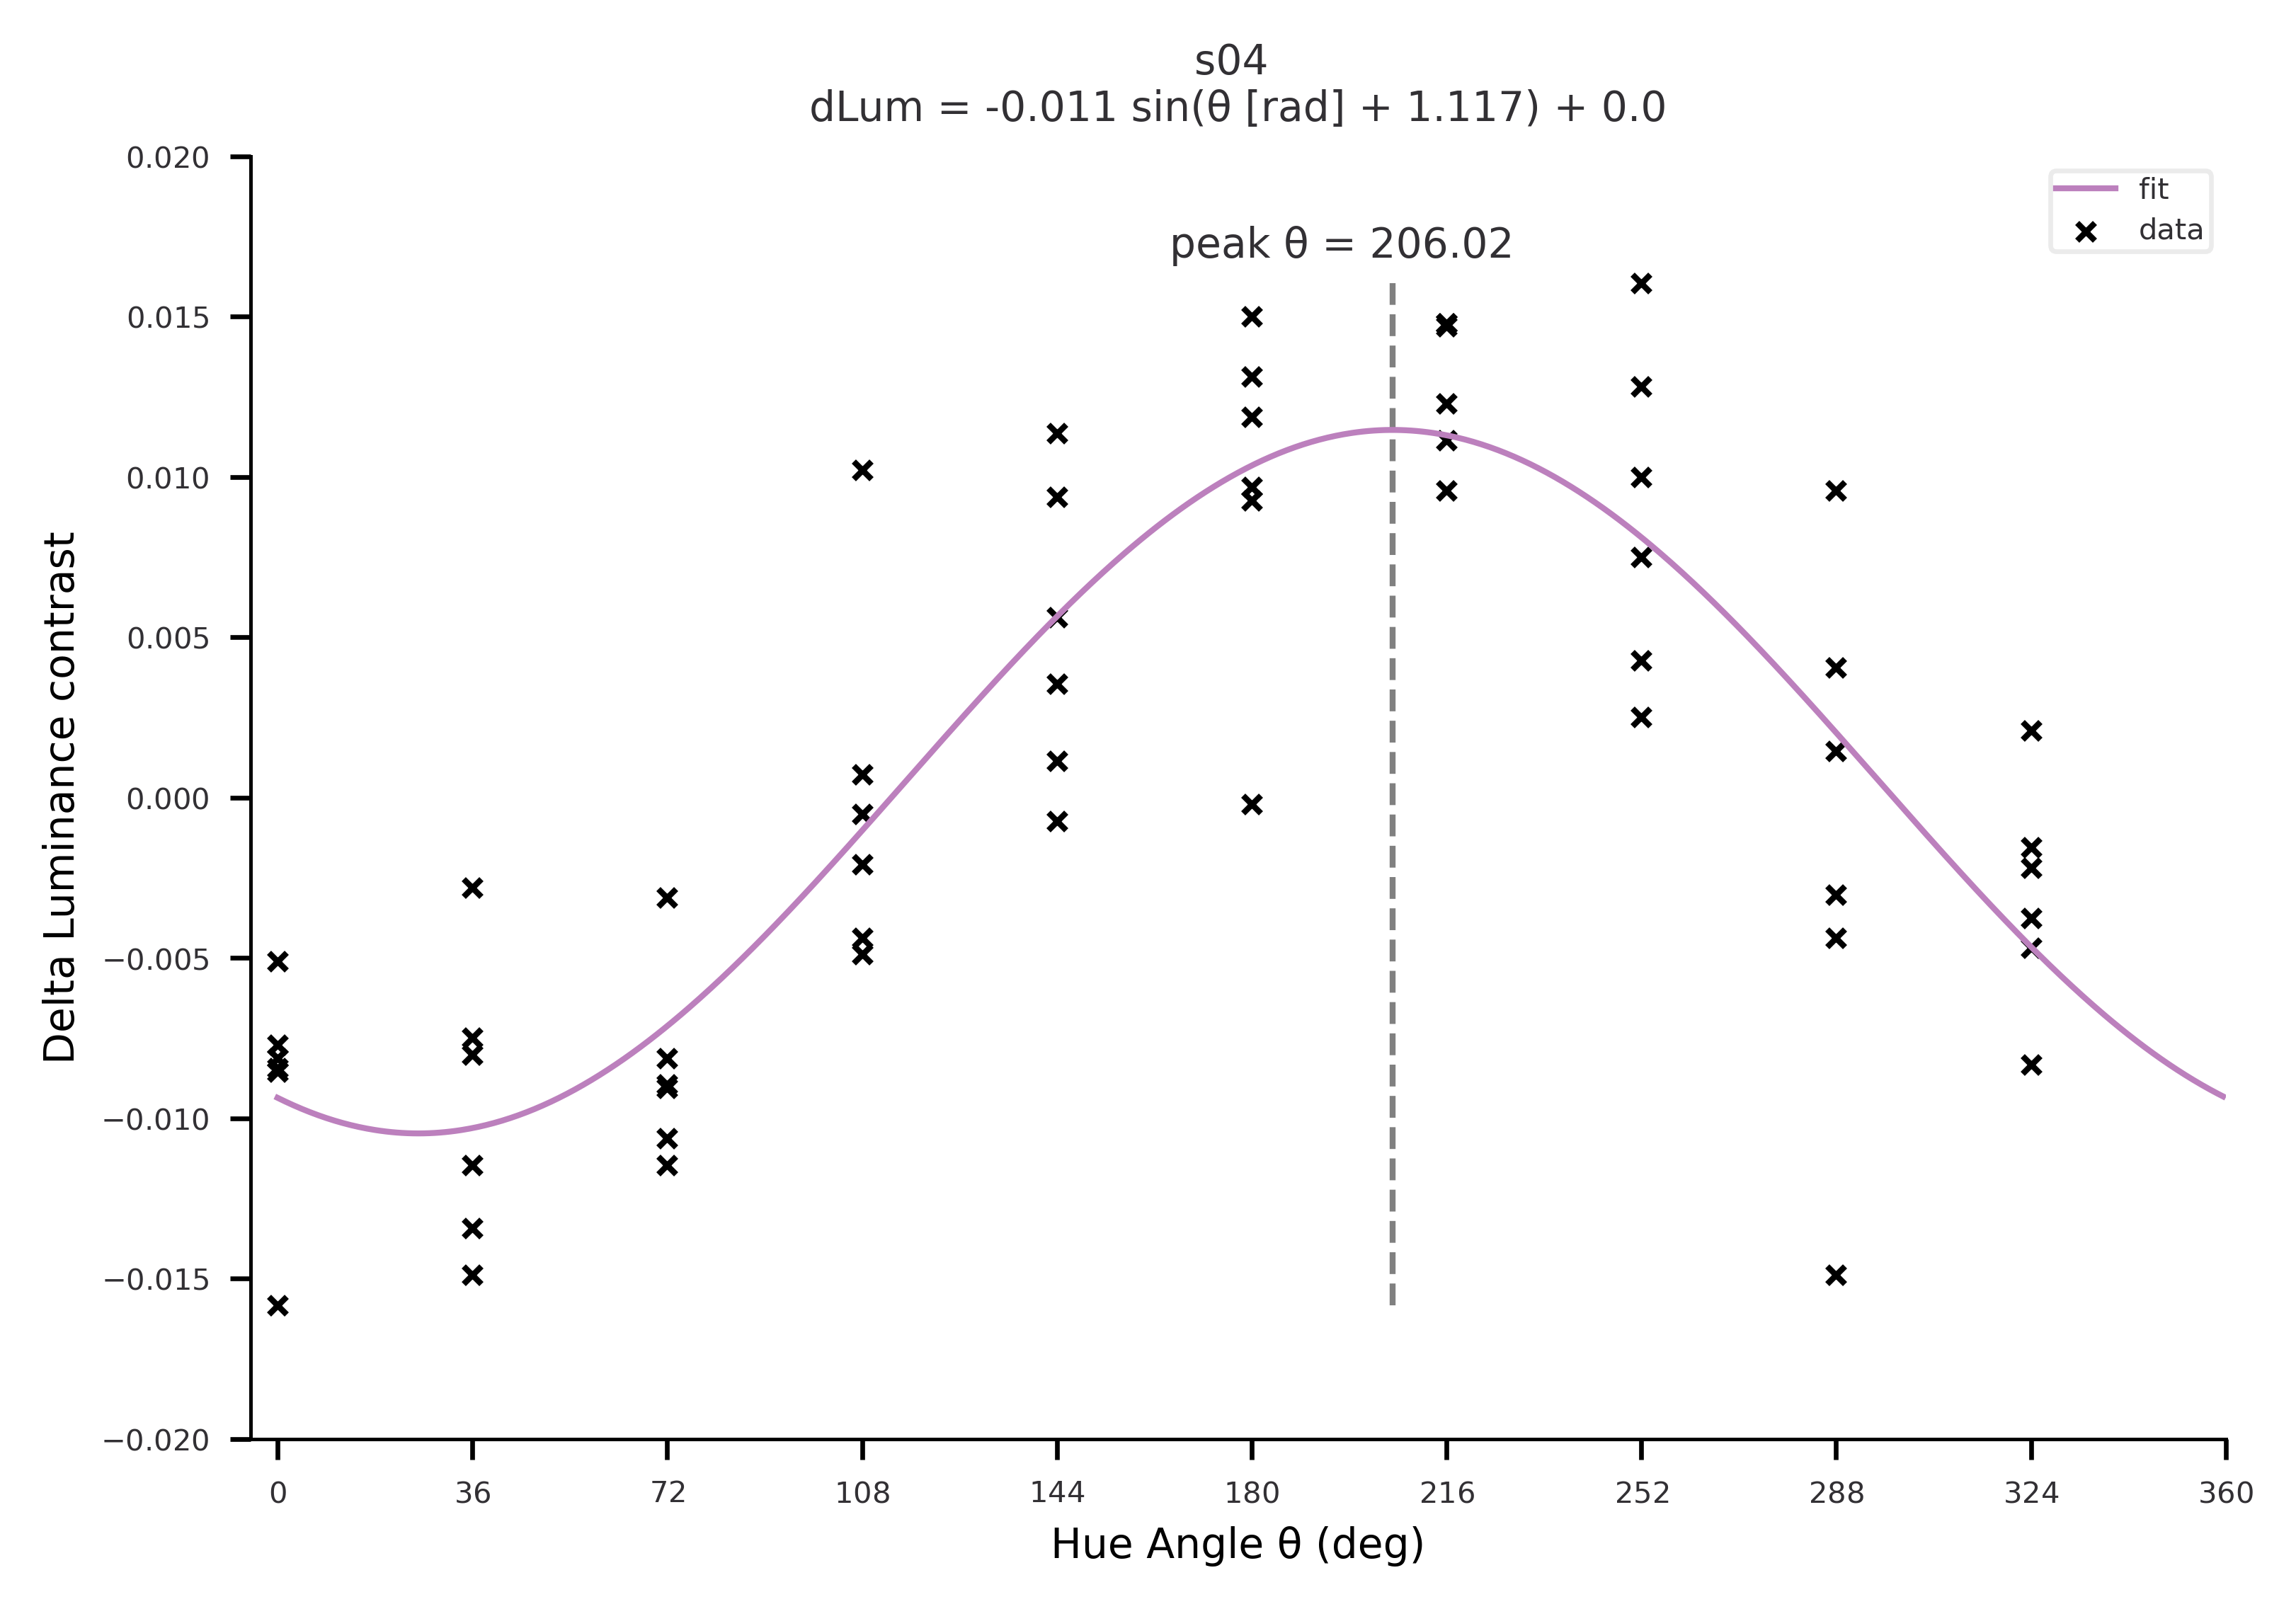

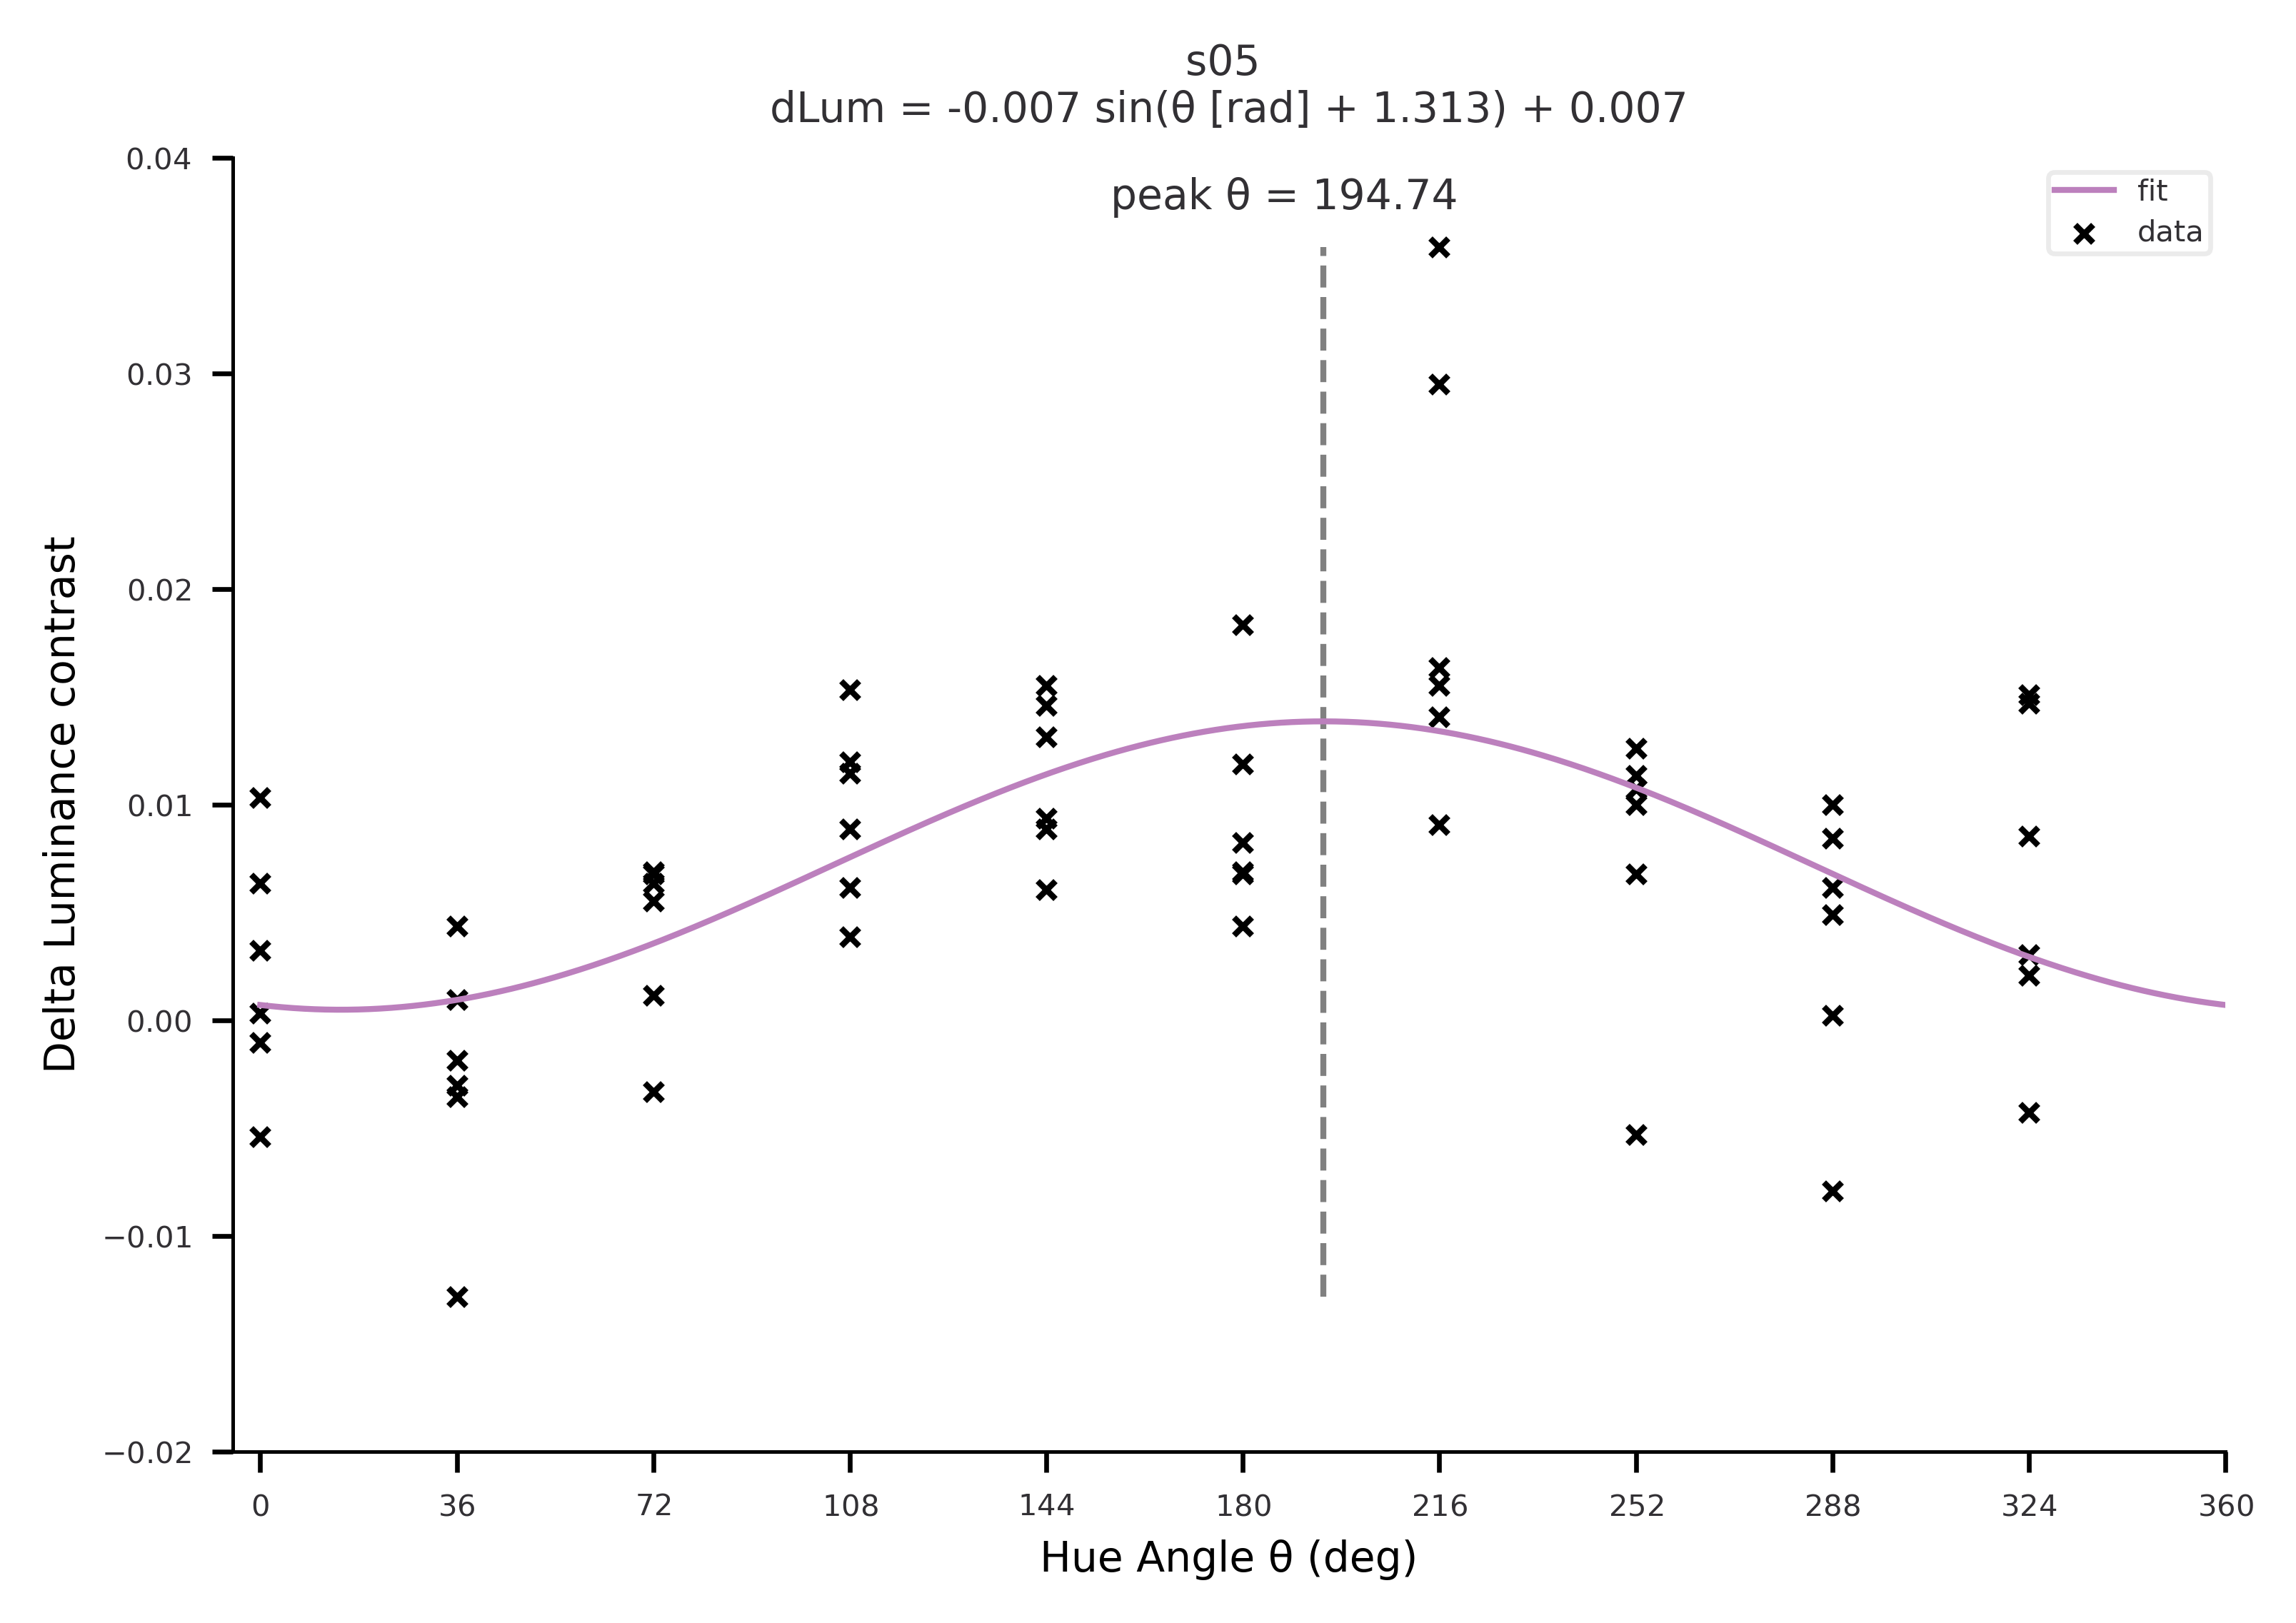

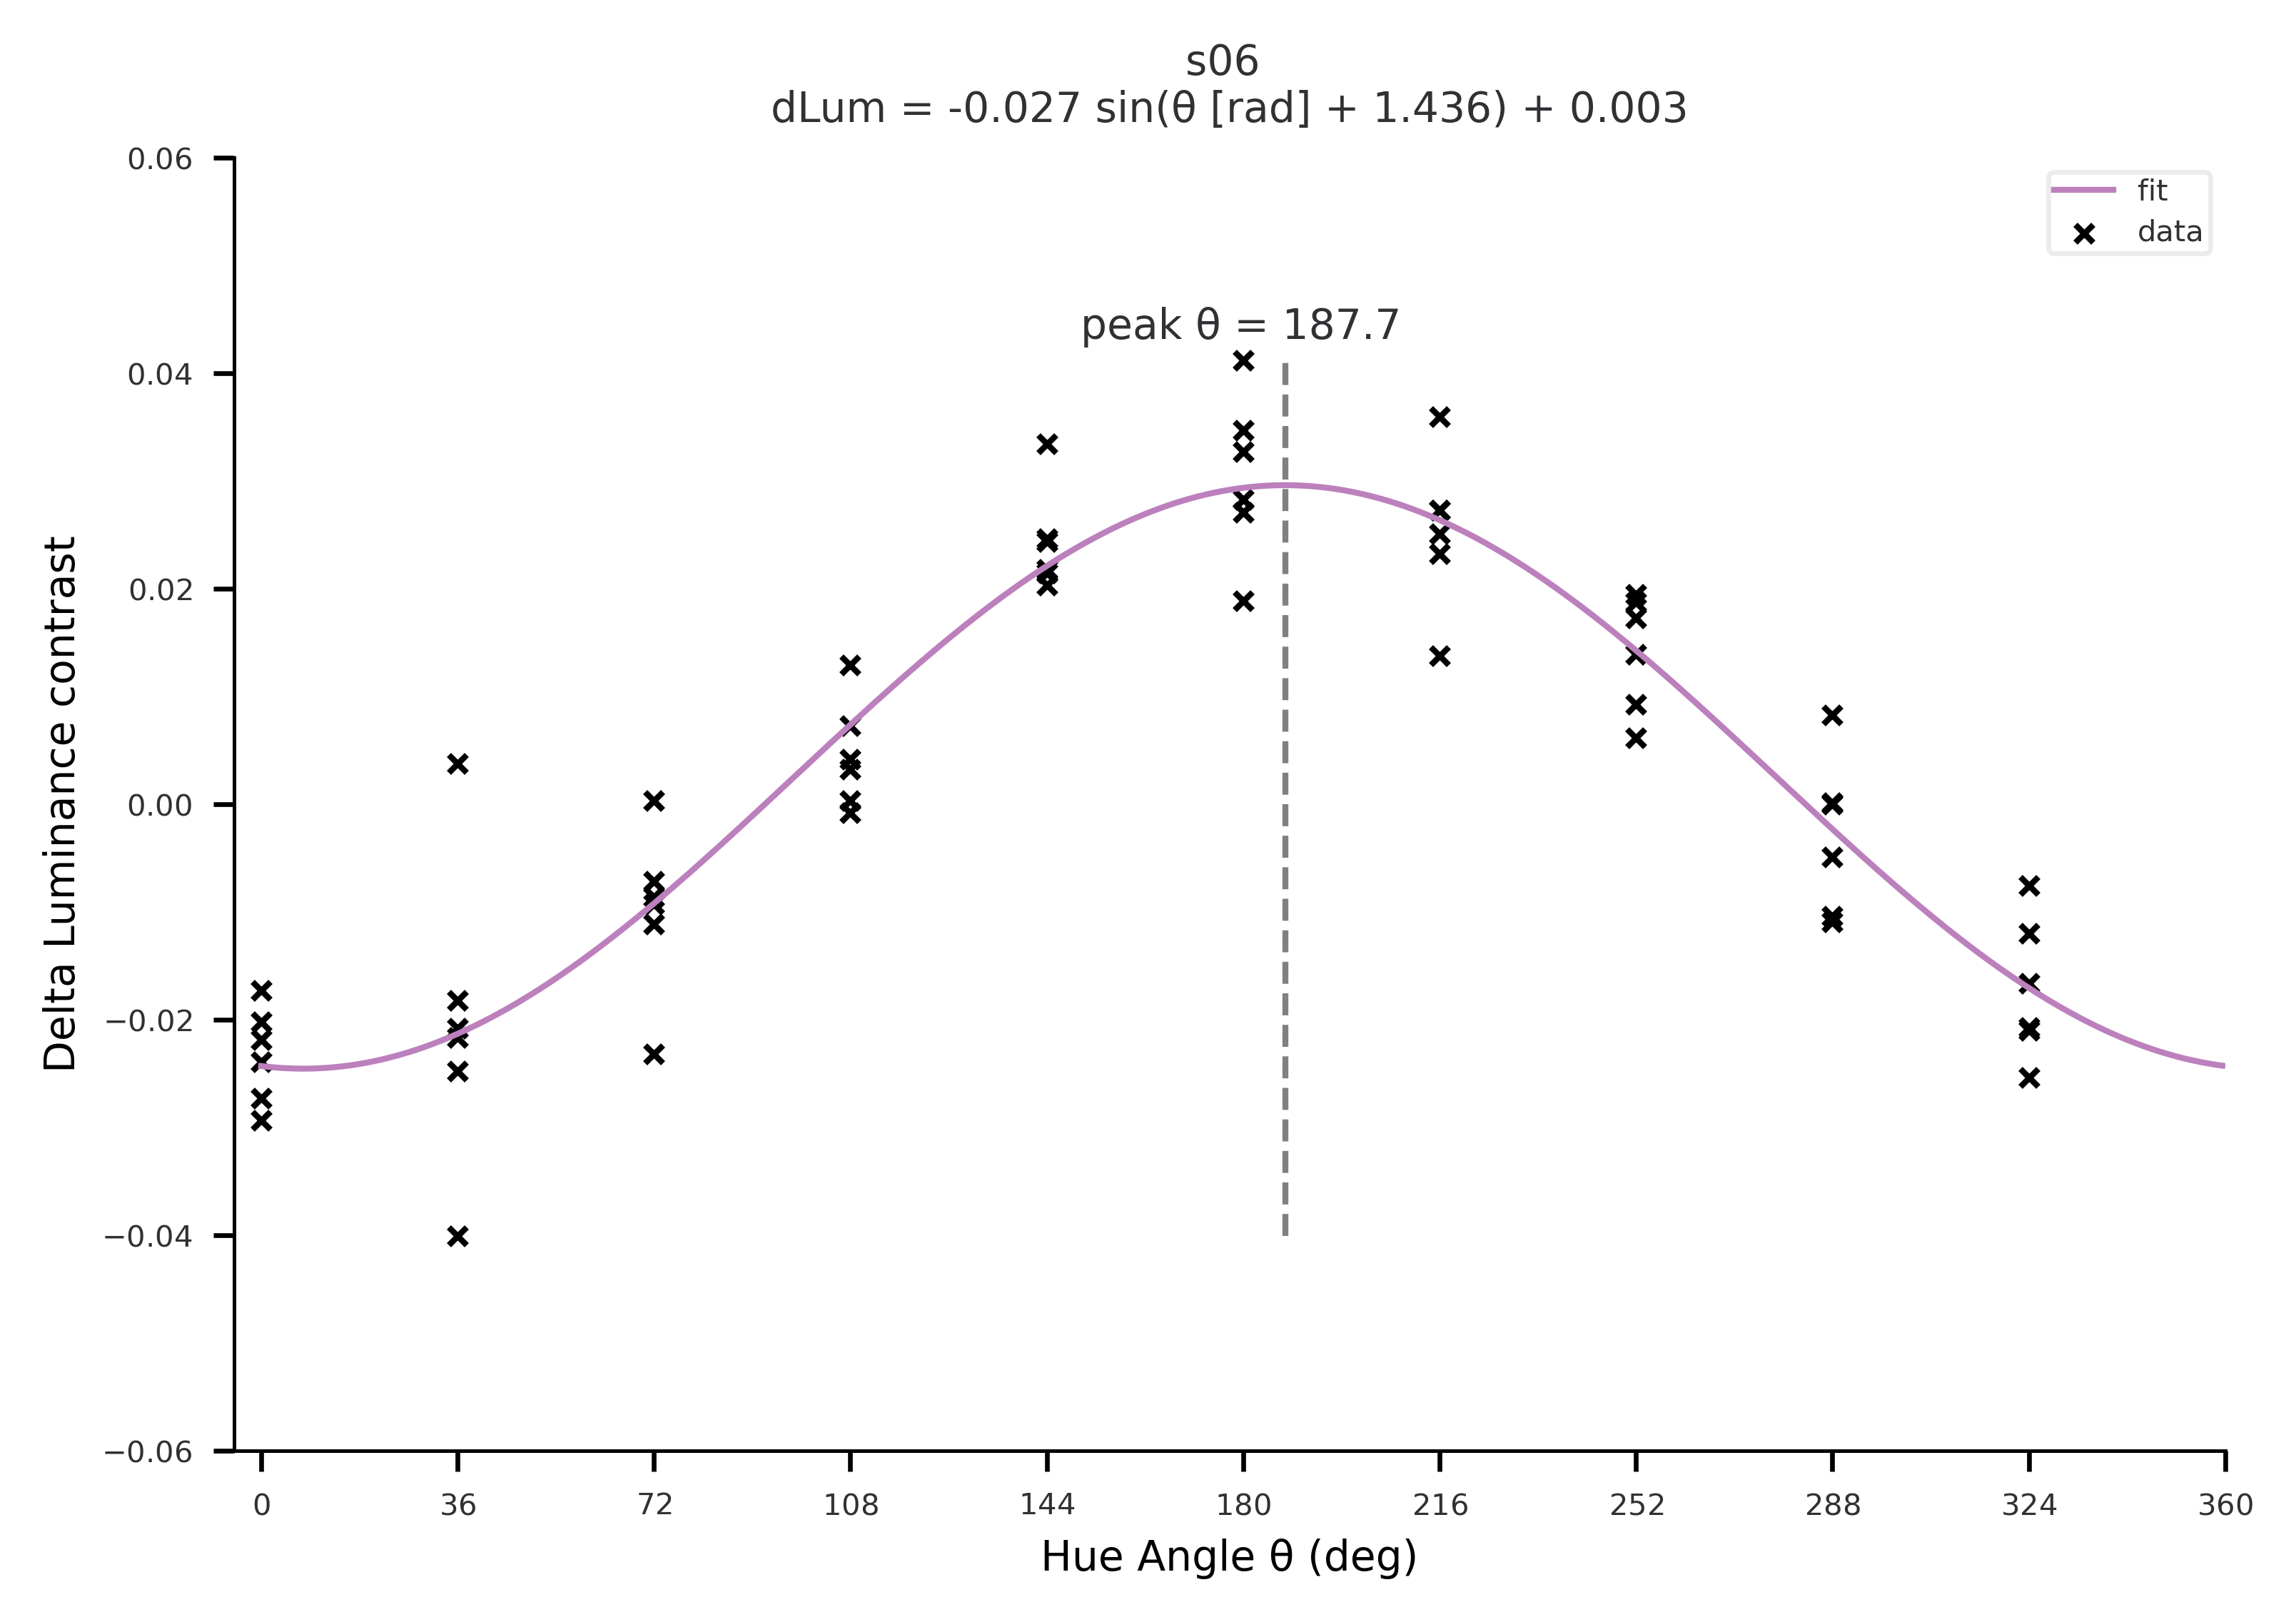

In [71]:
plot_isoslant('s01')
plot_isoslant('s02')
plot_isoslant('s03')
plot_isoslant('s04')
plot_isoslant('s05')
plot_isoslant('s06')

# Unique Hues

In [236]:
sub = 's05'
dat = LoadData(sub, data_path='data/unique_hue').read_data(convert_judge=False).reset_index()

if sub == 's06':
    dat = LoadData(sub, data_path='data/unique_hue', sel_ses_idx=[1, 2, 3, 4, 5, 6]).read_data(convert_judge=False).reset_index()

dat['sub'] = sub

dat['estimate_rad'] = np.deg2rad(dat['estimate'].astype(float))
dat.head()


index  sub i_rep unique_hue random_start estimate      RT     time_index  \
0  trial_1  s05   0.0       blue   116.666667    120.6   23.66  20220615T1644   
1  trial_2  s05   0.0      green   235.897436    220.8   25.94  20220615T1644   
2  trial_3  s05   0.0     yellow   321.666667    276.2  101.84  20220615T1644   
3  trial_4  s05   0.0        red     2.564103    334.8   46.42  20220615T1644   
4  trial_5  s05   1.0     yellow   319.615385    298.2    15.3  20220615T1644   

   estimate_rad  
0      2.104867  
1      3.853687  
2      4.820599  
3      5.843362  
4      5.204572

## Check outliers

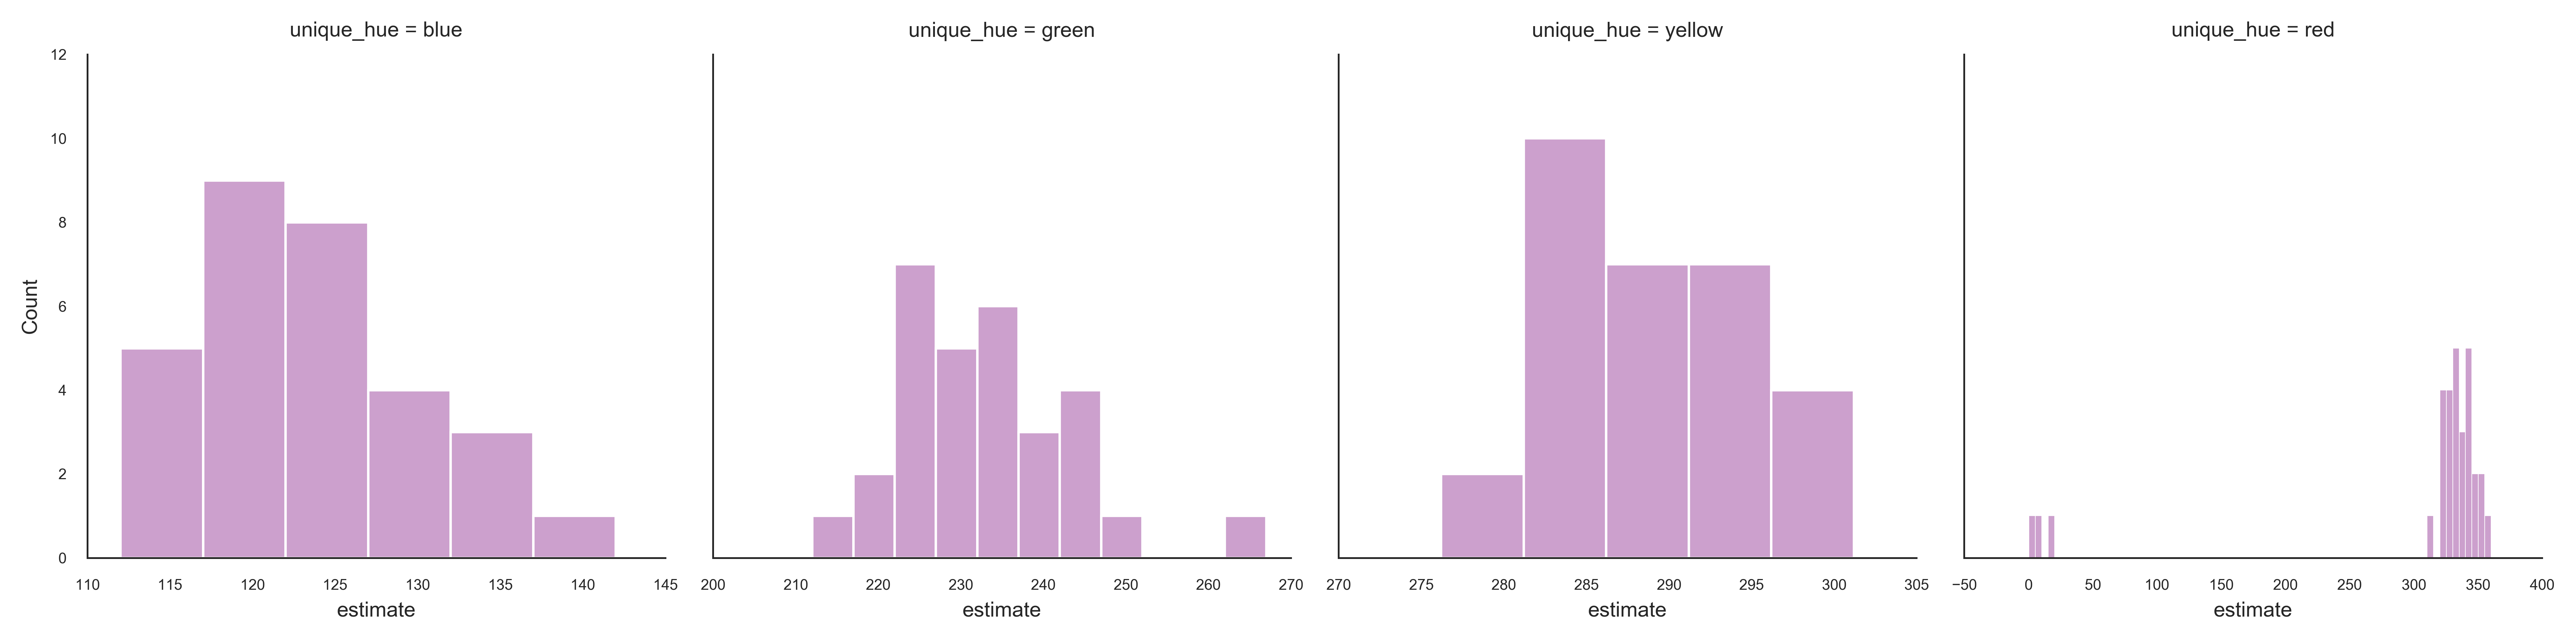

In [237]:
g = sns.FacetGrid(dat, col='unique_hue', sharex=False)
g.map(sns.histplot, 'estimate', binwidth=5)

In [238]:
mdat_raw = dat.groupby(['sub', 'unique_hue'])['estimate_rad'].agg([stats.circmean, stats.circstd]).reset_index()
mdat_raw['circmean_deg'] = mdat_raw['circmean']/np.pi * 180
mdat_raw['circstd_deg'] = mdat_raw['circstd']/np.pi * 180

coef = 3
mdat_raw['lim_low'] = mdat_raw['circmean'] - coef * mdat_raw['circstd']
mdat_raw['lim_high'] = mdat_raw['circmean'] + coef * mdat_raw['circstd']

mdat_raw['lim_low'] = mdat_raw['lim_low'].apply(lambda x: x + np.pi * 2 if x <= 0 else x)
mdat_raw['lim_high'] = mdat_raw['lim_high'].apply(lambda x: x - np.pi * 2 if x > np.pi*2 else x)

mdat_raw.head()

sub unique_hue  circmean   circstd  circmean_deg  circstd_deg   lim_low  \
0  s05       blue  2.158759  0.122939    123.687773     7.043873  1.789943   
1  s05      green  4.068422  0.182278    233.103383    10.443777  3.521587   
2  s05        red  5.916257  0.252534    338.976552    14.469145  5.158654   
3  s05     yellow  5.053544  0.101440    289.546743     5.812076  4.749224   

   lim_high  
0  2.527575  
1  4.615256  
2  0.390674  
3  5.357864

In [239]:
for hue in mdat_raw.unique_hue.unique():
    dat.loc[dat.unique_hue == hue, 'lim_low'] = mdat_raw[mdat_raw.unique_hue == hue]['lim_low'].values[0]
    dat.loc[dat.unique_hue == hue, 'lim_high'] = mdat_raw[mdat_raw.unique_hue == hue]['lim_high'].values[0]


def rad_in_lim(r, lower, upper):
    return (r - lower) % (2 * np.pi) > (upper - lower) % (2 * np.pi)
    
dat['outlier'] = dat.apply(lambda x: rad_in_lim(x.estimate_rad, x.lim_low, x.lim_high), axis=1)

print(f"outlier trials: ")
dat[dat.outlier == True]


outlier trials: 


index  sub i_rep unique_hue random_start estimate    RT     time_index  \
86  trial_7  s05   1.0      green   234.871795    265.2  3.78  20220615T1707   

    estimate_rad   lim_low  lim_high  outlier  
86      4.628613  3.521587  4.615256     True

In [240]:
# remove outlier trials

dat = dat[dat.outlier == False]
dat.to_csv(f'data_analysis/unique_hues/{sub}_dat.csv', index=False)

len(dat)


119

## Compute means and var after removing outliers

In [241]:
mdat = dat.groupby(['sub', 'unique_hue'])['estimate_rad'].agg([stats.circmean, stats.circstd]).reset_index()
mdat['circmean_deg'] = mdat['circmean']/np.pi * 180
mdat['circstd_deg'] = mdat['circstd']/np.pi * 180

mdat.to_csv(f'data_analysis/unique_hues/{sub}_unique_hues.csv', index=False)

mdat.head()


sub unique_hue  circmean   circstd  circmean_deg  circstd_deg
0  s05       blue  2.158759  0.122939    123.687773     7.043873
1  s05      green  4.049883  0.152781    232.041204     8.753702
2  s05        red  5.916257  0.252534    338.976552    14.469145
3  s05     yellow  5.053544  0.101440    289.546743     5.812076

Text(0.5, 1.0, 'SD')

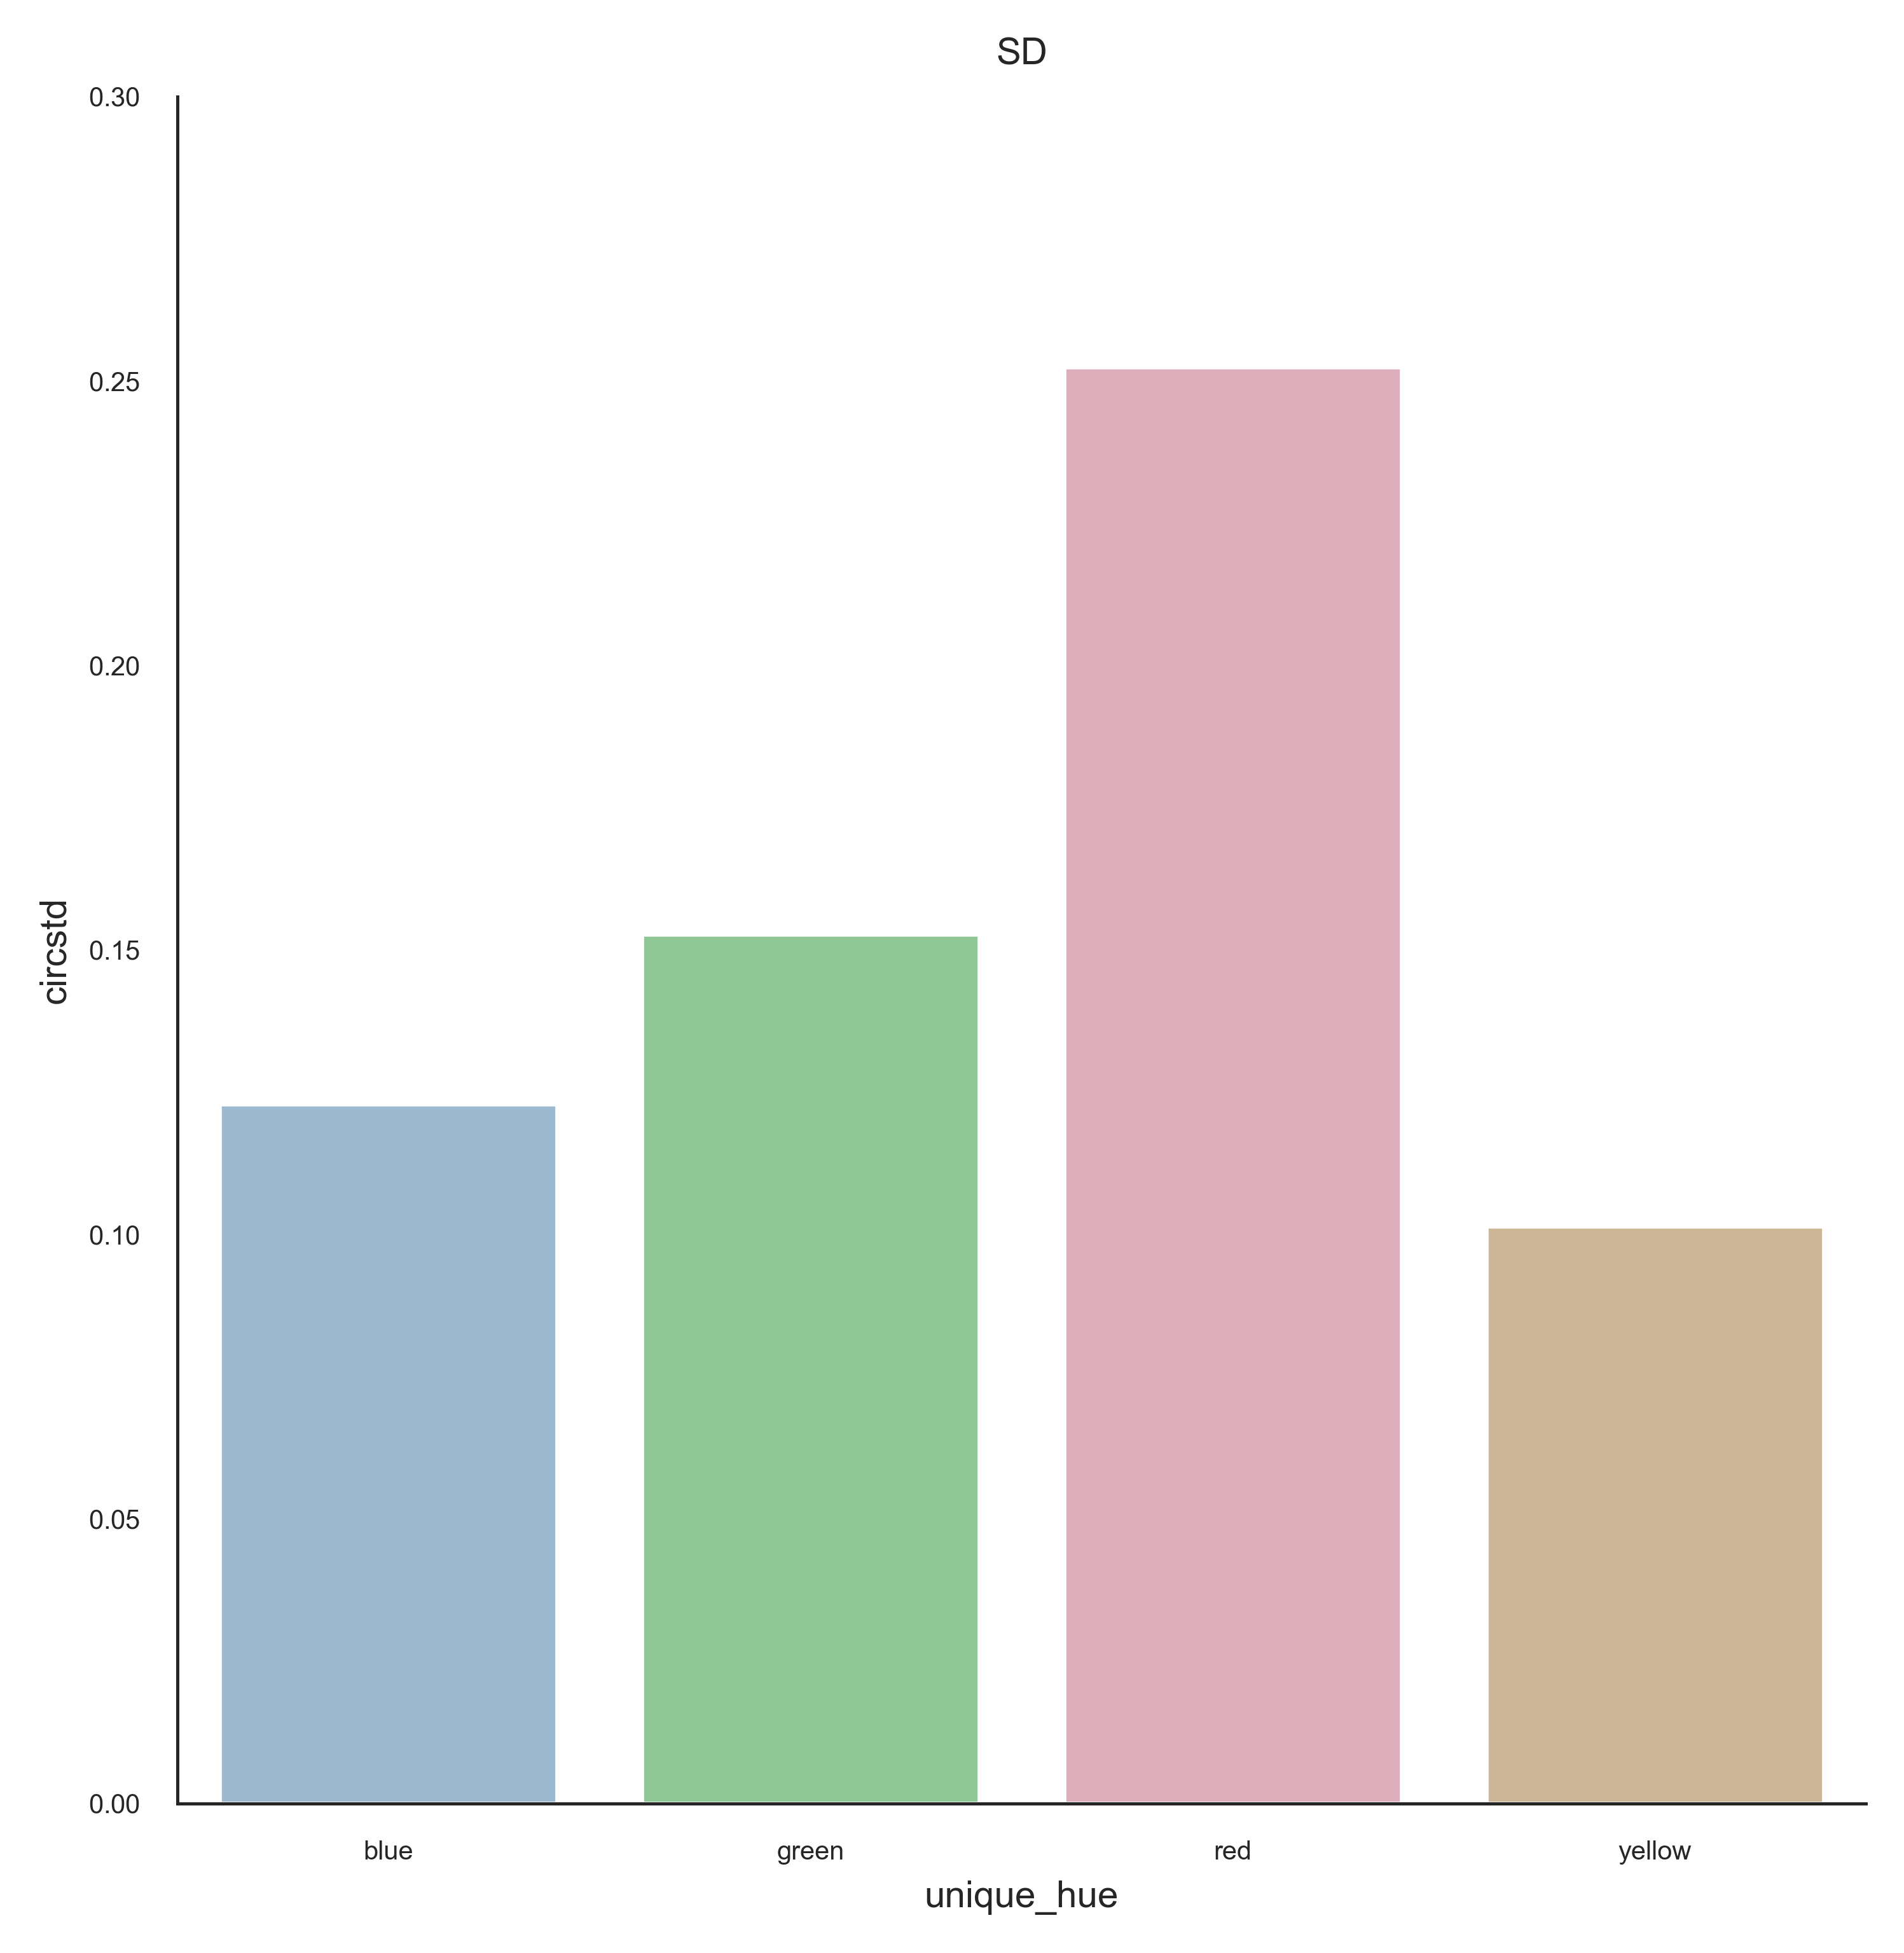

In [242]:
g = sns.catplot(data=mdat, x='unique_hue', y='circstd', palette=palette, kind='bar')
plt.title('SD')


[]

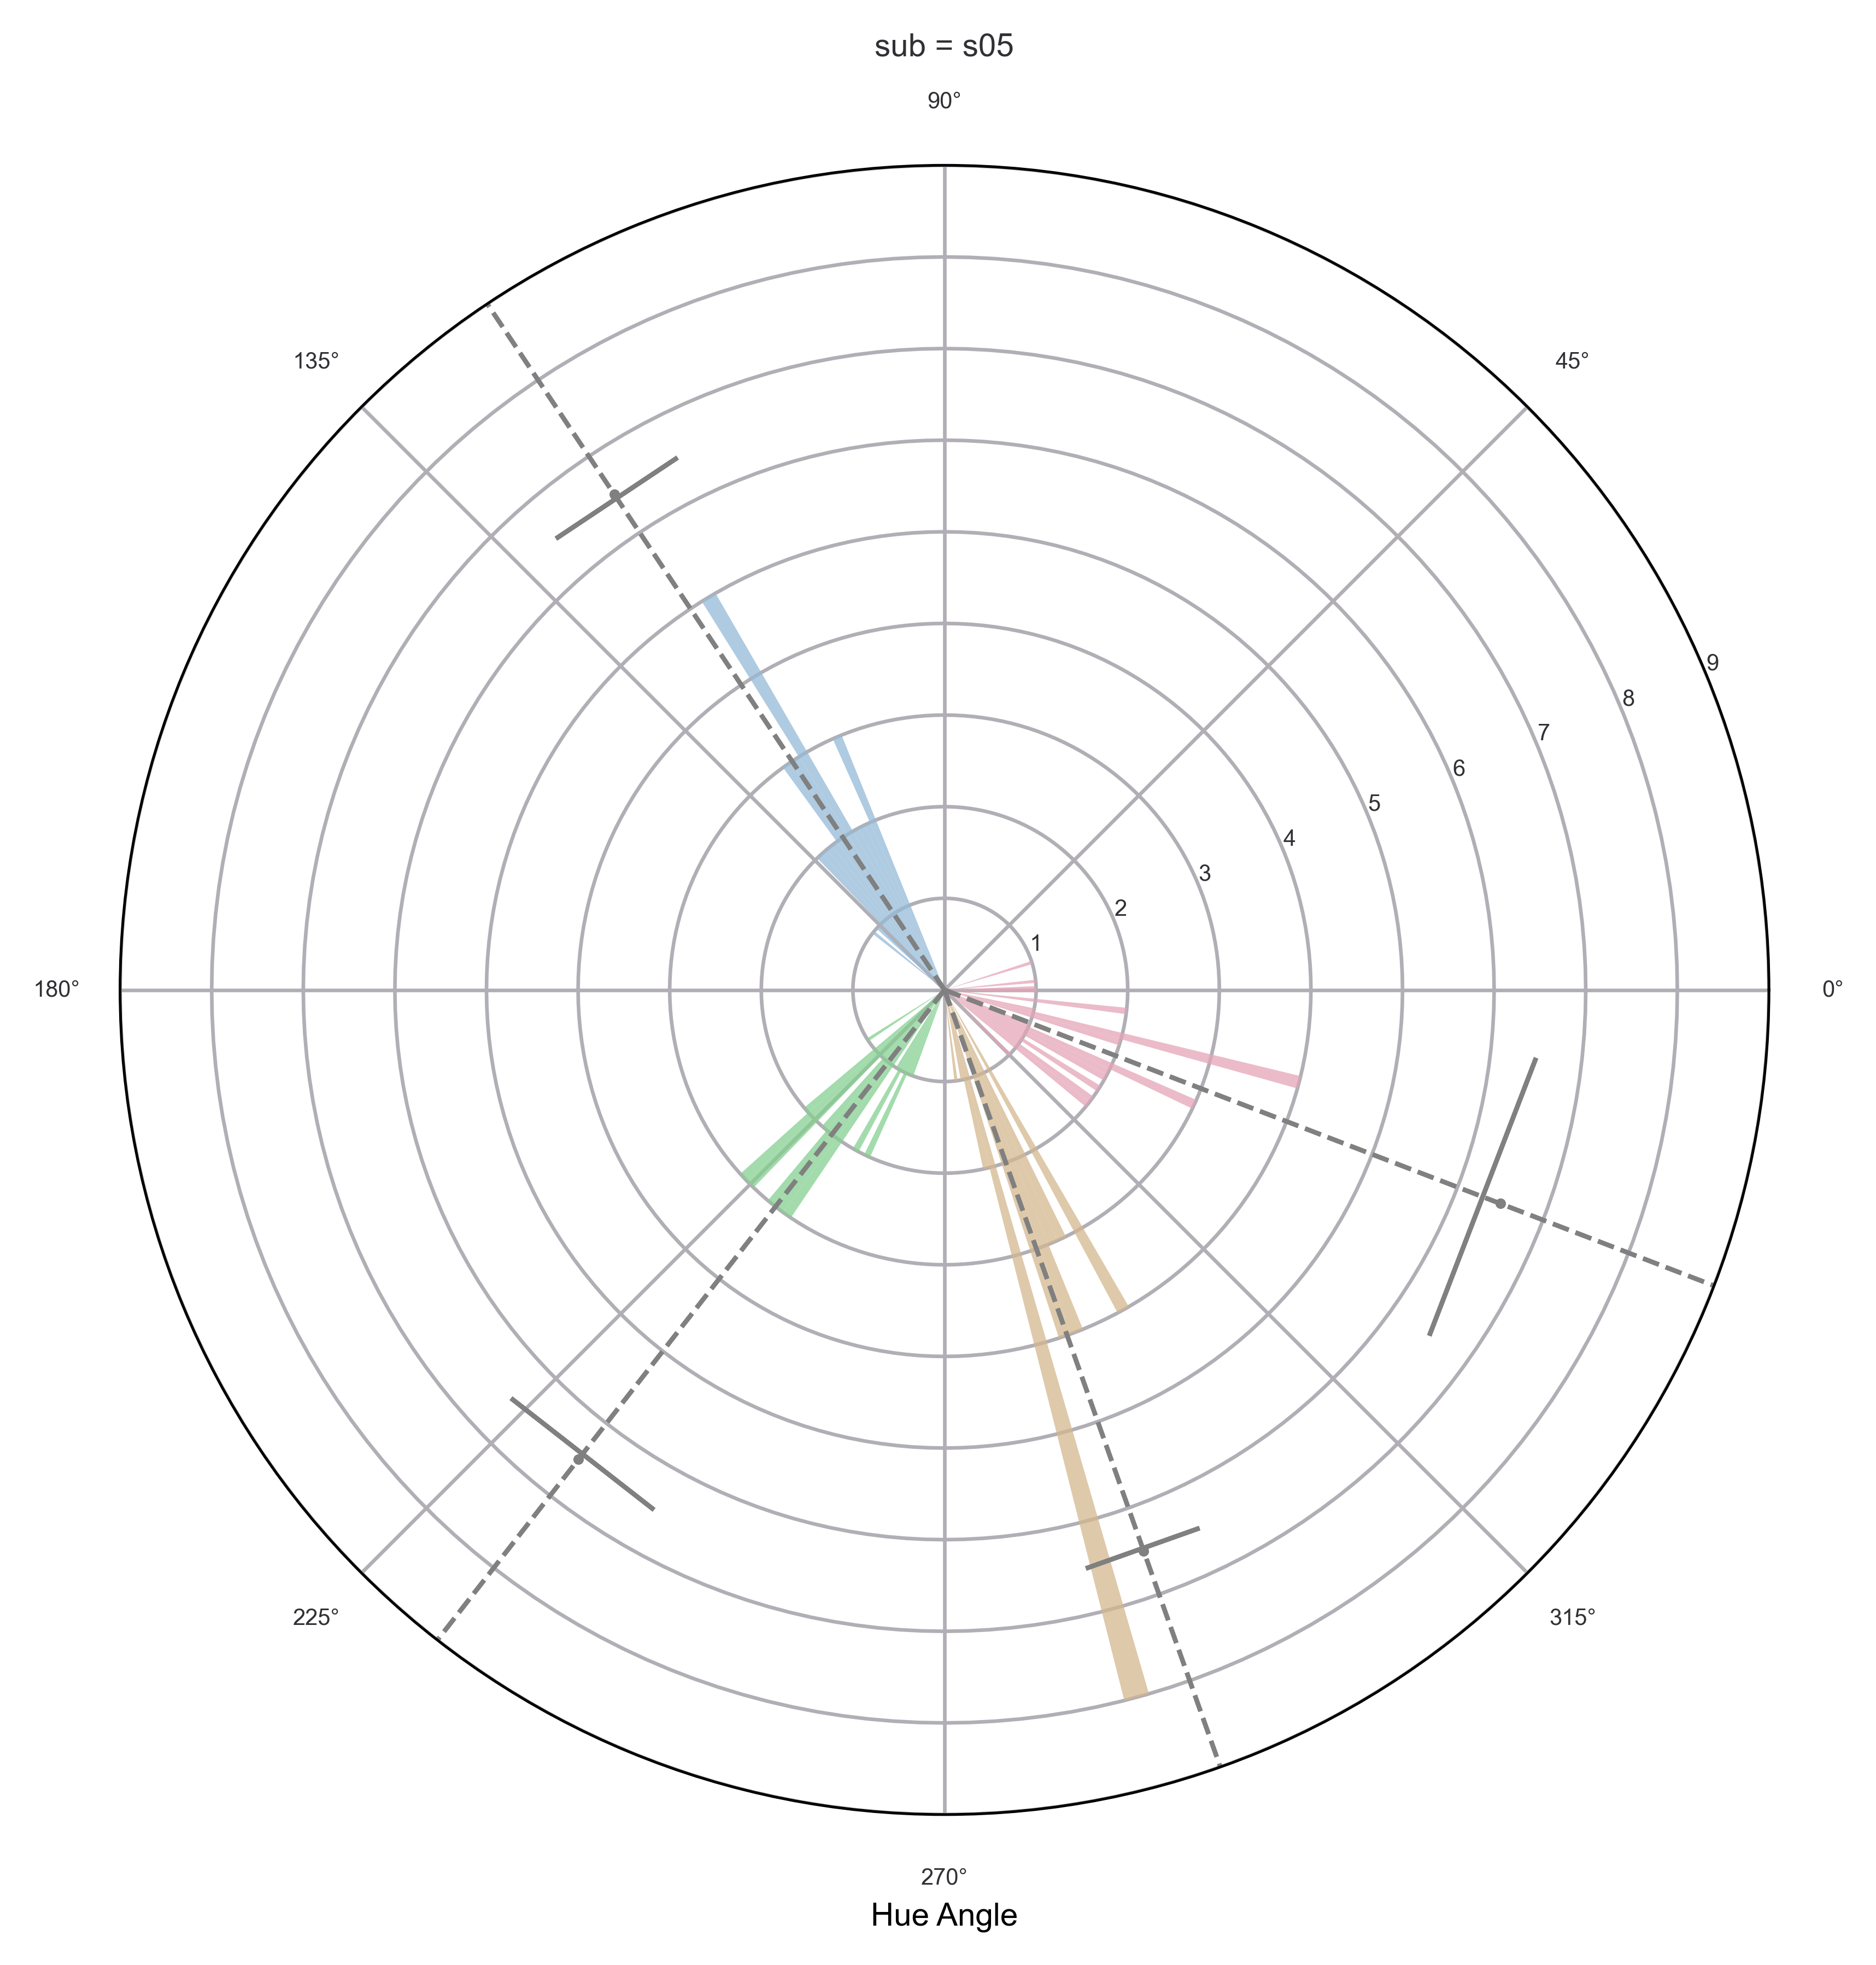

In [256]:

g = sns.FacetGrid(data=dat, col='sub', hue='unique_hue', subplot_kws=dict(projection='polar'), height=6, despine=False, palette=palette)
[g.map(plt.axvline, x=vi, color='gray', linestyle='--', alpha=0.7) for vi in mdat.circmean.values]
g.map(sns.histplot, 'estimate_rad', binwidth=np.pi/90, linewidth=0) # bin width as 2 deg

y = 6.5

g.map(plt.scatter, x=mdat.circmean.values, y=np.repeat(y, 4), s=2.,color='gray')# color=list(palette.values()))
g.map(plt.errorbar, x=mdat.circmean.values, y=np.repeat(y, 4), xerr=mdat.circstd.values, linestyle='', capsize=3.,color='gray')# ecolor=list(palette.values()))
g.set(xlabel='Hue Angle', ylabel='')
# plt.suptitle("Unique Hues", x=0, y=1.05)
# plt.tight_layout()

plt.savefig(f'data_analysis/figures/unique_hues/{sub}_hues.pdf')
plt.plot()


## All subjects

In [2]:
import glob

dat = pd.concat(map(pd.read_csv, glob.glob('data_analysis/unique_hues/*dat.csv')), ignore_index=True)

mdat = pd.concat(map(pd.read_csv, glob.glob('data_analysis/unique_hues/*unique_hues.csv')), ignore_index=True)

In [3]:
pd.pivot_table(data=dat, values='estimate', index='sub', columns=['unique_hue'],  aggfunc='count')

unique_hue  blue  green  red  yellow
sub                                 
s01           30     30   29      29
s02           30     30   30      29
s03           30     30   30      30
s05           30     29   30      30
s06           30     30   30      30

In [ ]:
dat.pivot(index=['sub','cond'], columns = 'fromColumn', values = 'valueColumn').reset_index()


[Text(0, 0, 's01'),
 Text(0, 0, 's02'),
 Text(0, 0, 's03'),
 Text(0, 0, 's05'),
 Text(0, 0, 's06')]

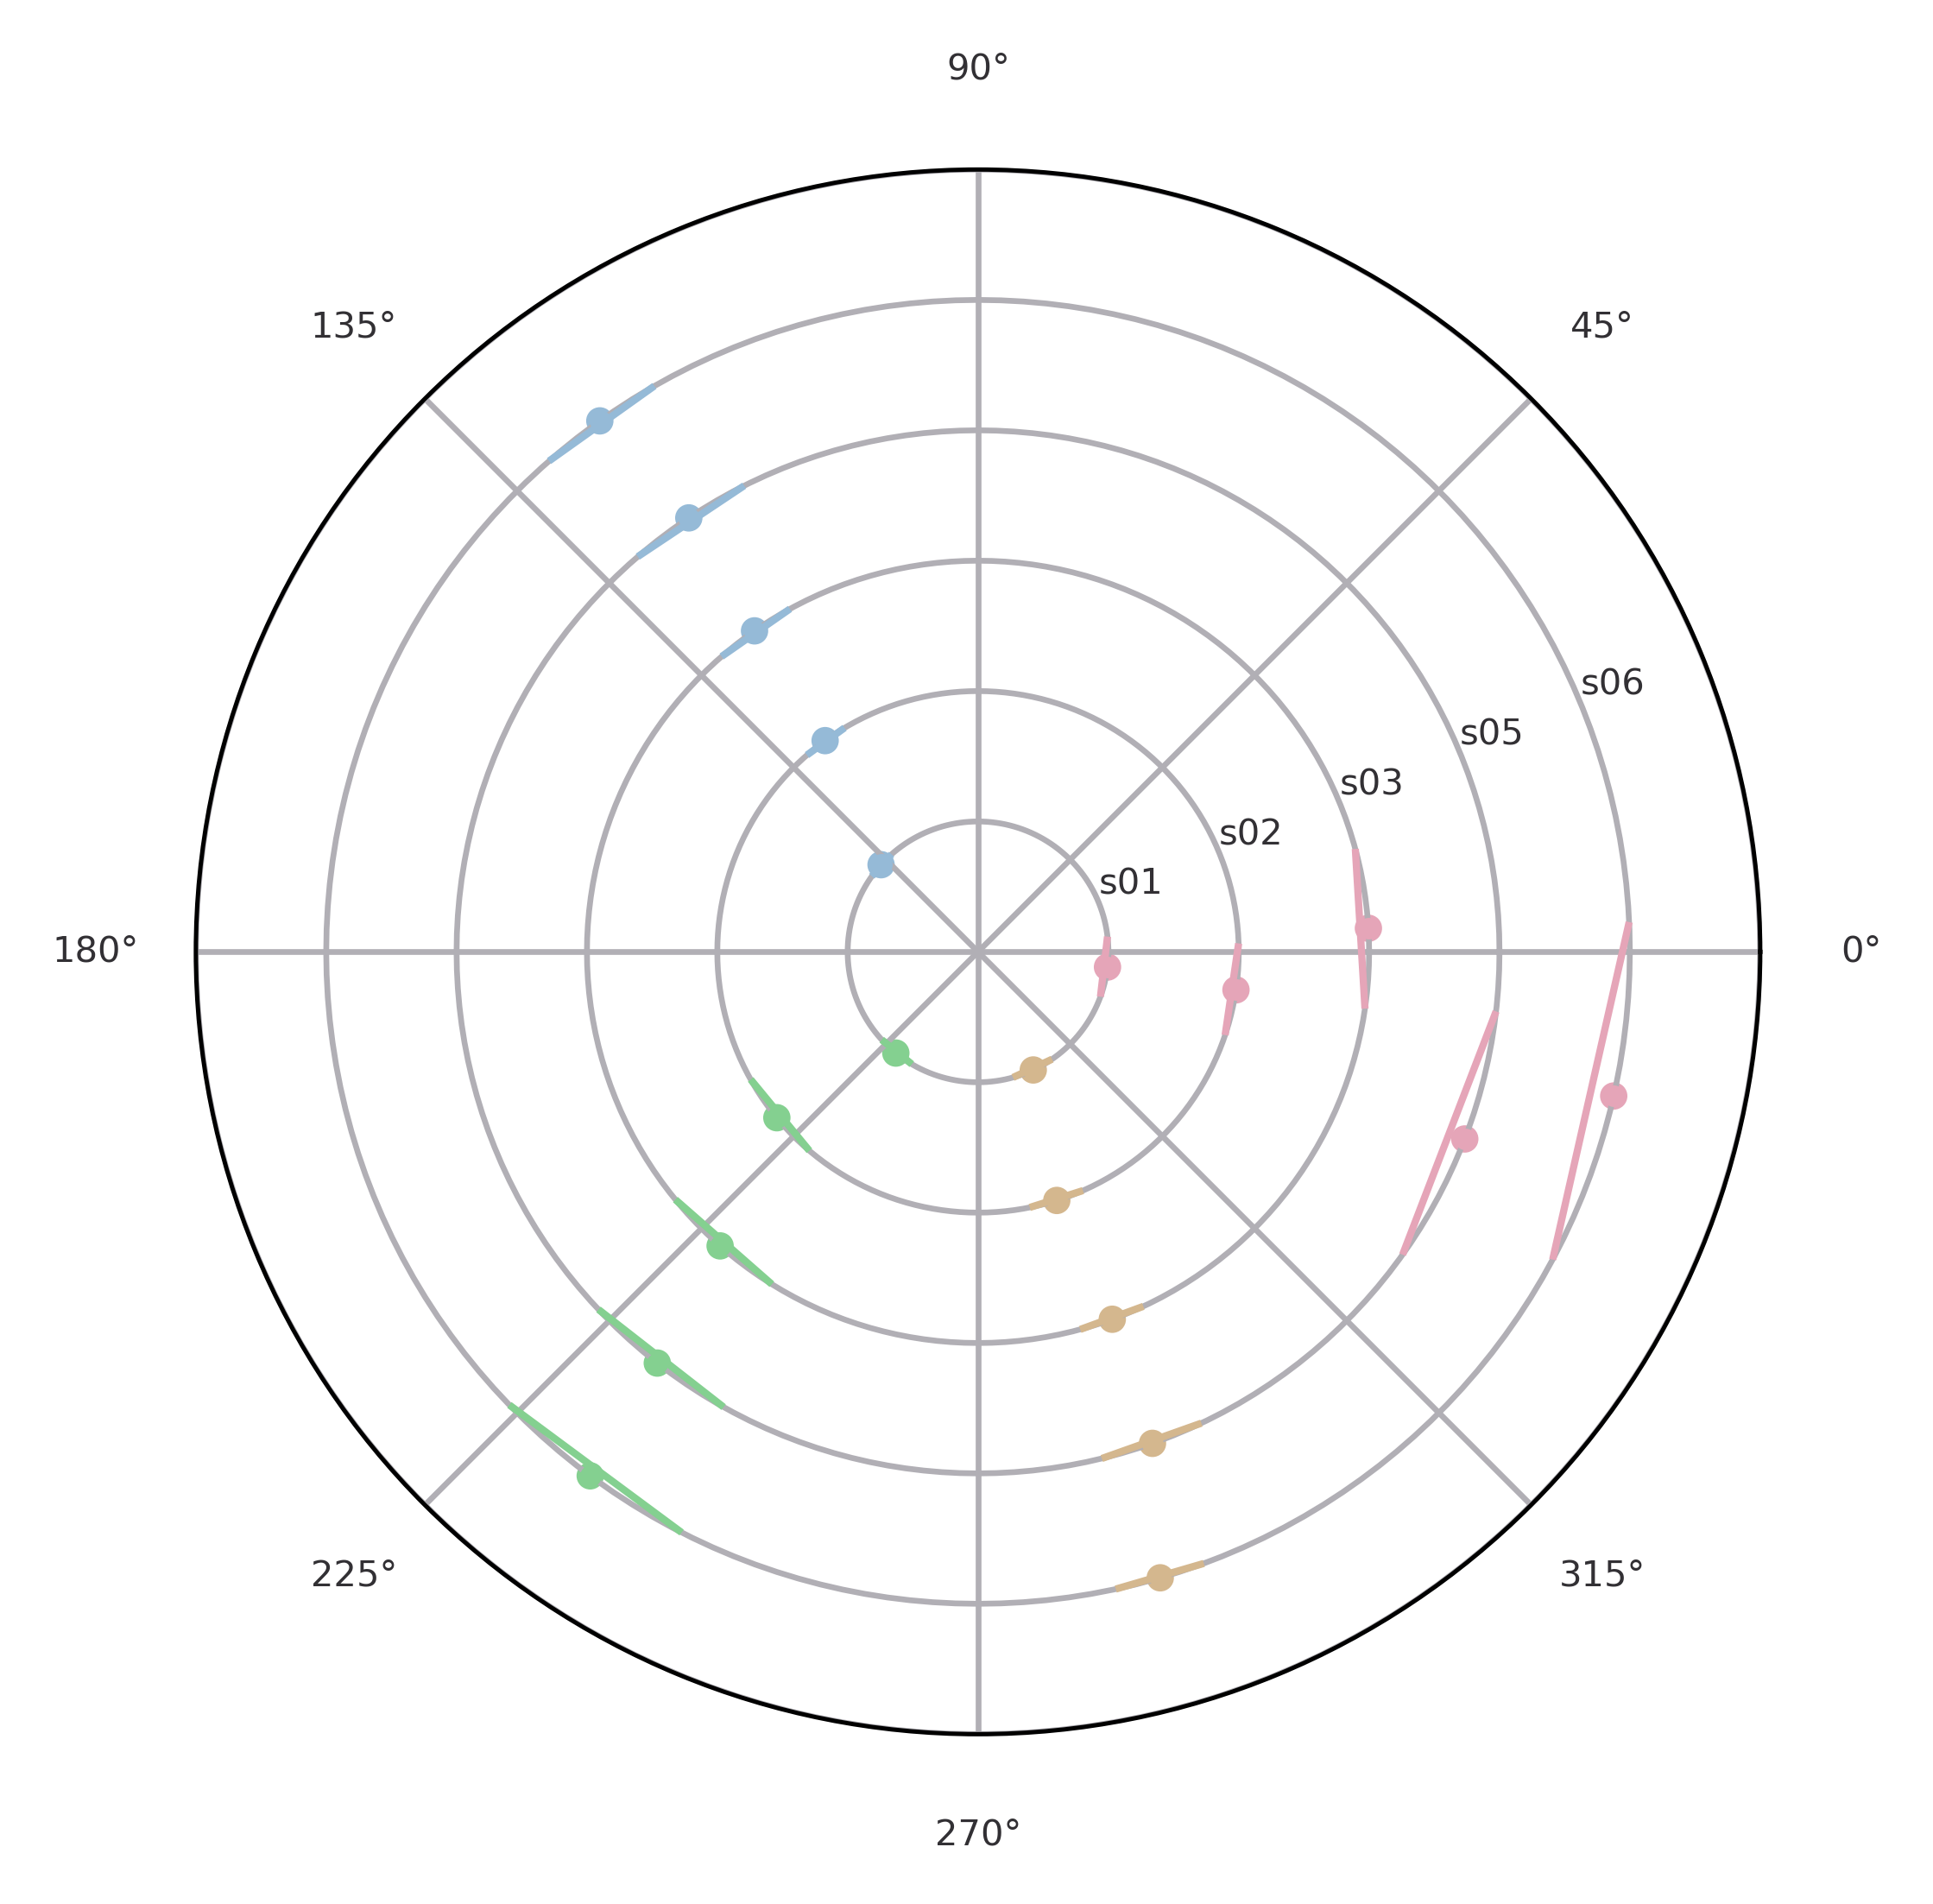

In [38]:
ax = plt.subplot(projection='polar')
subs = mdat.sort_values(by='sub')['sub'].unique()
for id_s, s in enumerate(subs):
    for h in list(palette.keys()):
        this_mat = mdat.loc[(mdat['sub']==s) & (mdat.unique_hue==h)]
        y = np.arange(len(subs))[id_s]+1
        ax.scatter(this_mat.circmean, np.repeat(y, len(this_mat)), edgecolors=palette[h], facecolors='none')
        ax.errorbar(this_mat.circmean, np.repeat(y, len(this_mat)), xerr=this_mat.circstd, c=palette[h], fmt='o')

ax.set_yticklabels(subs)

[]

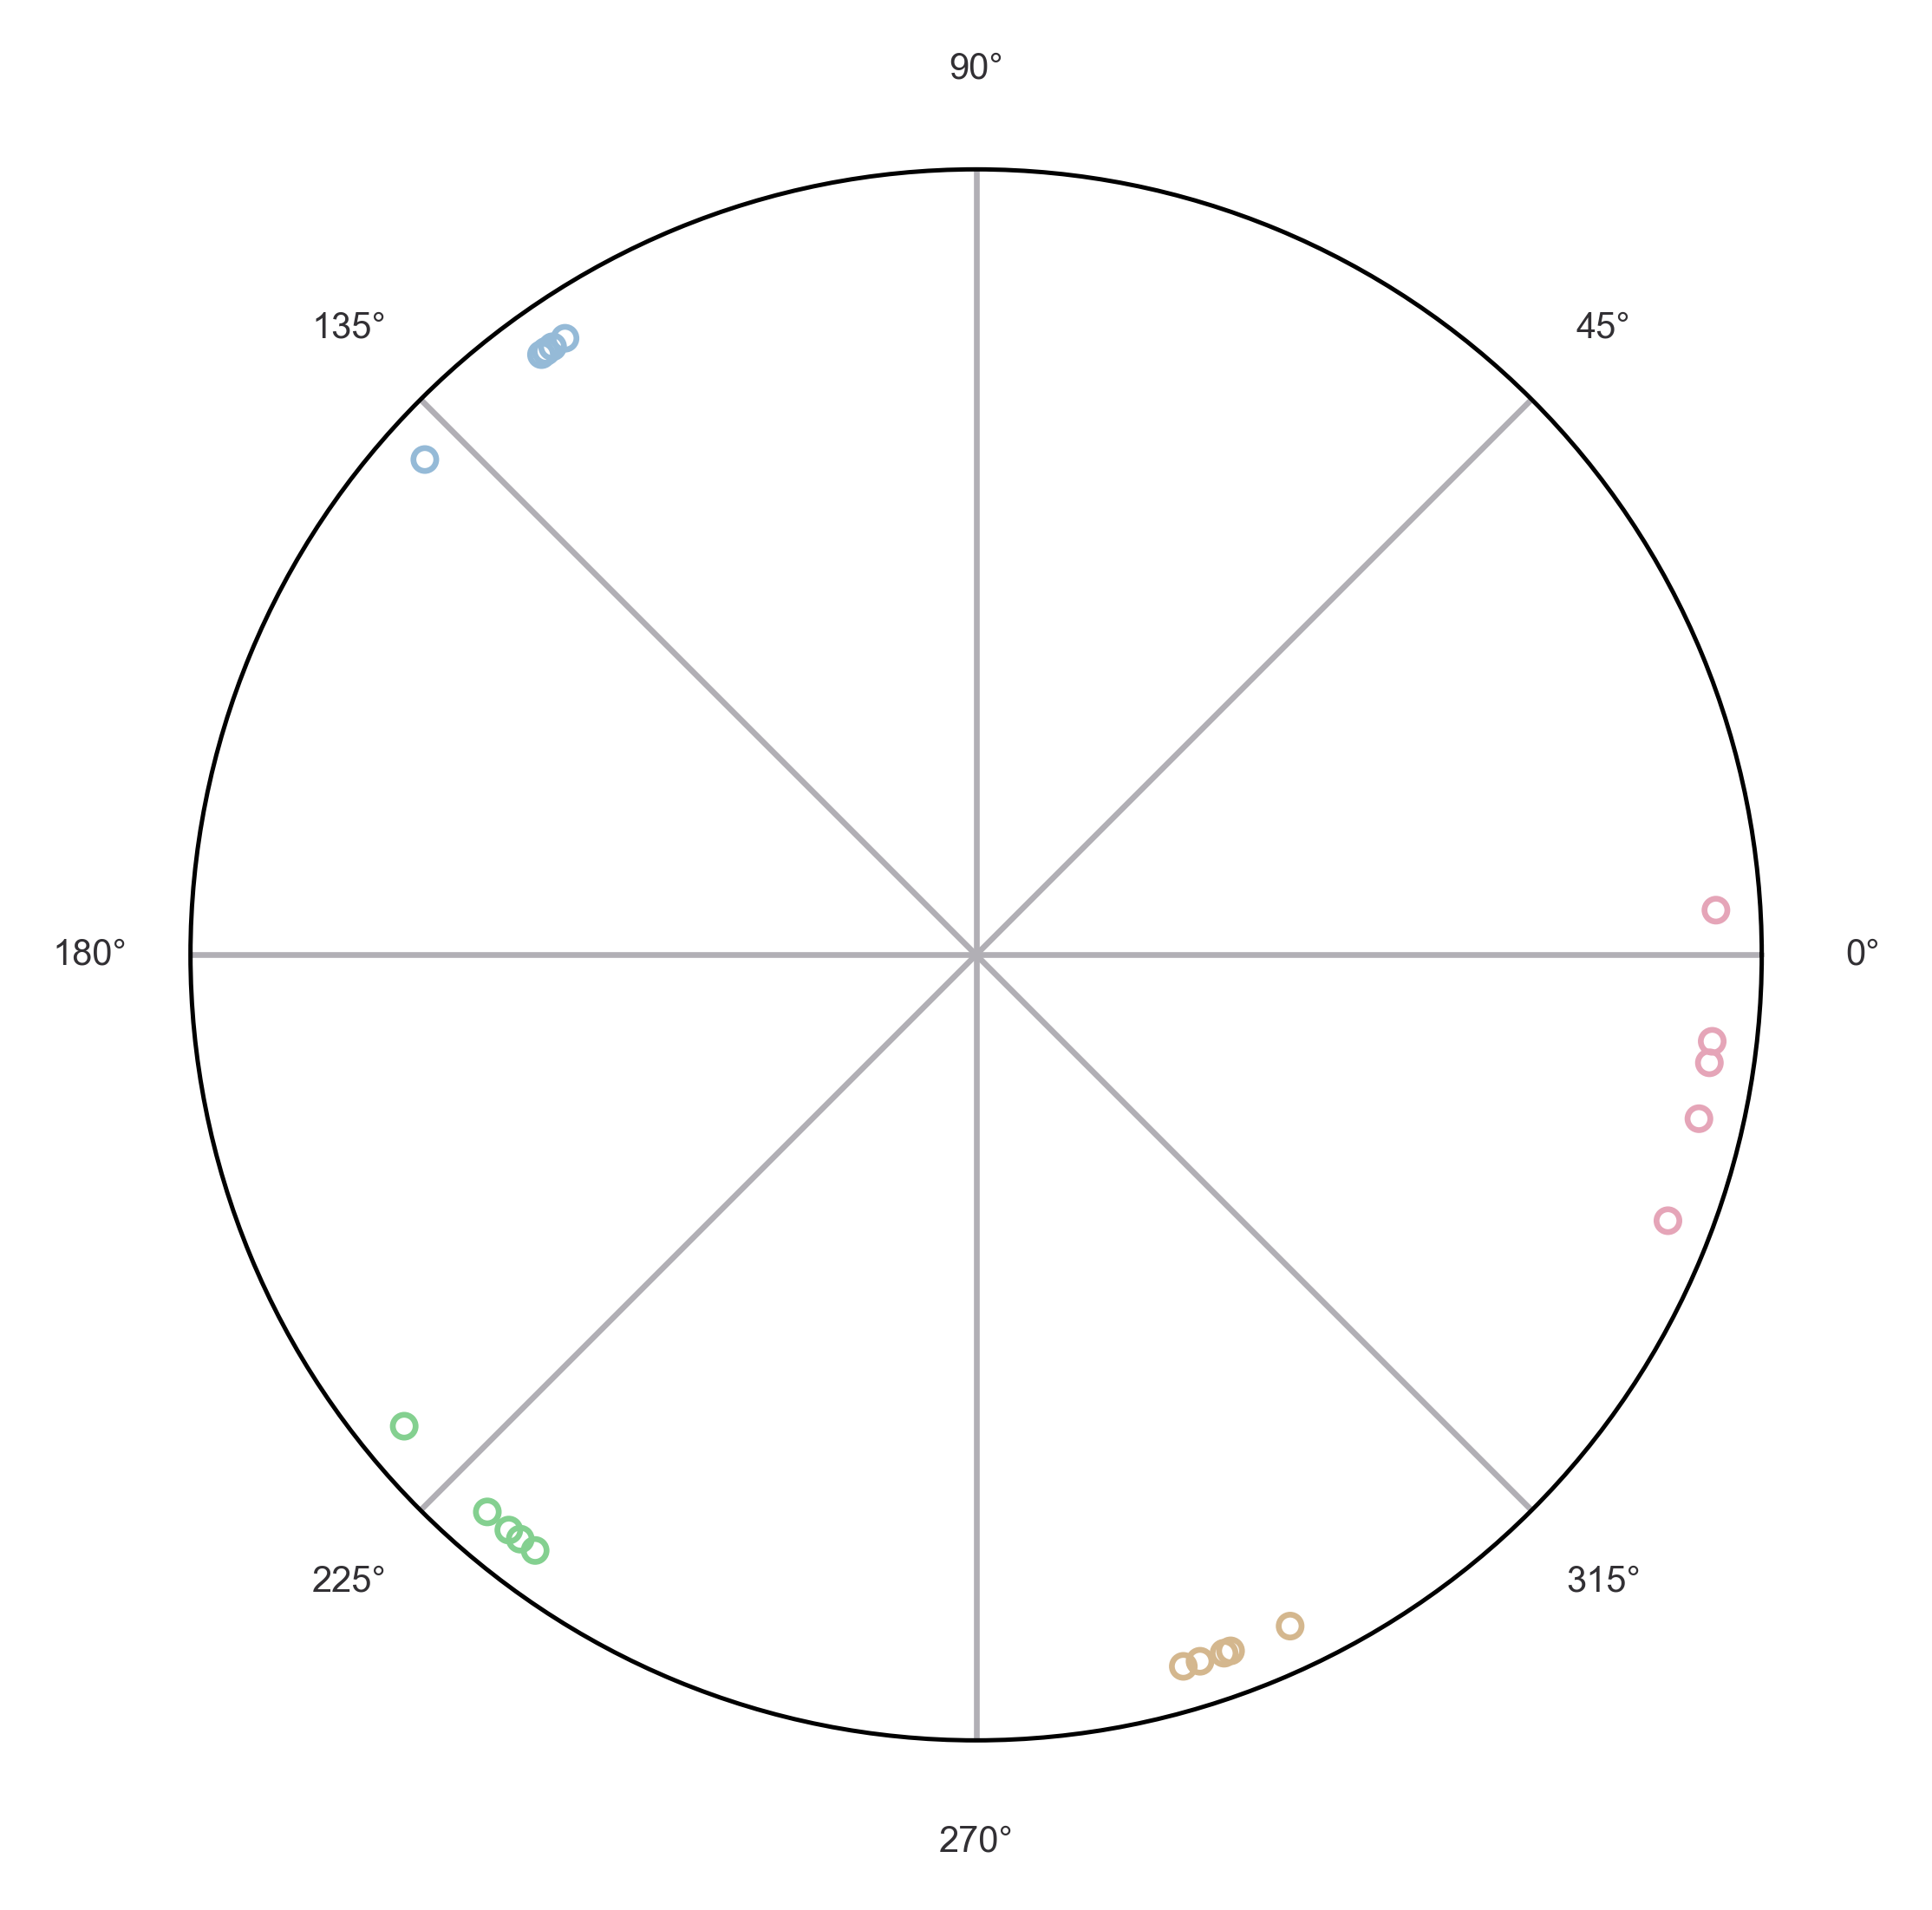

In [309]:
ax = plt.subplot(projection='polar')
subs = mdat.sort_values(by='sub')['sub'].unique()
for s in subs:
    for h in list(palette.keys()):
        this_mat = mdat.loc[(mdat['sub']==s) & (mdat.unique_hue==h)]
        y = 0.1
        ax.scatter(this_mat.circmean, np.repeat(y, len(this_mat)), edgecolors=palette[h], facecolors='none', s=10)
        # ax.errorbar(this_mat.circmean, np.repeat(y, len(this_mat)), xerr=this_mat.circstd, c=palette[h], fmt='o')
        # ax.annotate(s, (this_mat.circmean, y) )
ax.set_yticklabels([])
ax.set_yticks([])

## Crosstalk across trials

In [26]:
import glob

dat = pd.concat(map(pd.read_csv, glob.glob('data_analysis/unique_hues/*dat.csv')), ignore_index=True)

mdat = pd.concat(map(pd.read_csv, glob.glob('data_analysis/unique_hues/*unique_hues.csv')), ignore_index=True)

# mdat = dat.groupby(['sub', 'unique_hue'])['estimate_rad'].agg([stats.circmean, stats.circstd]).reset_index()
# mdat['circmean_deg'] = mdat['circmean']/np.pi * 180
# mdat['circstd_deg'] = mdat['circstd']/np.pi * 180

mdat.head()

sub unique_hue  circmean   circstd  circmean_deg  circstd_deg
0  s01       blue  2.409529  0.113609    138.055854     6.509291
1  s01      green  4.030205  0.149337    230.913736     8.556371
2  s01        red  6.166271  0.234286    353.301332    13.423585
3  s01     yellow  5.149894  0.165982    295.067218     9.510050
4  s06       blue  2.189815  0.099366    125.467132     5.693280

In [27]:
for s in mdat['sub'].unique():
    for h in mdat['unique_hue'].unique():
        dat.loc[(dat['sub']==s) & (dat.unique_hue==h), 'deviation'] = dat.loc[(dat['sub']==s) & (dat.unique_hue==h), 'estimate'] - mdat[(mdat['sub']==s) & (mdat.unique_hue==h)].circmean_deg.values[0]
dat.deviation = dat.deviation.apply(lambda x: x - 360 if x > 300 else x)
dat.deviation = dat.deviation.apply(lambda x: x + 360 if x < -300 else x)


In [28]:
for s in mdat['sub'].unique():
    for h in mdat['unique_hue'].unique():
        dat.loc[(dat['sub']==s) & (dat.unique_hue==h), 'z-score'] = dat.loc[(dat['sub']==s) & (dat.unique_hue==h), 'deviation'] / mdat[(mdat['sub']==s) & (mdat.unique_hue==h)].circstd_deg.values[0]

In [29]:
dat['previous_hue'] = dat.groupby('time_index')['unique_hue'].shift(periods=1)
dat.head()

index  sub  i_rep unique_hue  random_start  estimate      RT  \
0  trial_1  s05    0.0       blue    116.666667     120.6   23.66   
1  trial_2  s05    0.0      green    235.897436     220.8   25.94   
2  trial_3  s05    0.0     yellow    321.666667     276.2  101.84   
3  trial_4  s05    0.0        red      2.564103     334.8   46.42   
4  trial_5  s05    1.0     yellow    319.615385     298.2   15.30   

      time_index  estimate_rad   lim_low  lim_high  outlier previous_hue  \
0  20220615T1644      2.104867  1.789943  2.527575    False          NaN   
1  20220615T1644      3.853687  3.521587  4.615256    False         blue   
2  20220615T1644      4.820599  4.749224  5.357864    False        green   
3  20220615T1644      5.843362  5.158654  0.390674    False       yellow   
4  20220615T1644      5.204572  4.749224  5.357864    False          red   

  crosstalk  deviation   z-score  
0       NaN  -3.087773 -0.438363  
1       NaN -11.241204 -1.284166  
2       NaN -13.346743 -2.296381  
3       NaN  -4.176552 -0.288652  
4       NaN   8.653257  1.488841

In [30]:
dat['crosstalk'] = False
crosstalks = np.array([['blue', 'red', 'green'], 
                        ['green', 'blue', 'yellow'],
                        ['yellow', 'green', 'red'],
                        ['red', 'yellow', 'blue']])
for h in crosstalks:
    dat.loc[(dat.unique_hue == h[0]) & (dat.previous_hue == h[1]), 'crosstalk'] = True
    dat.loc[(dat.unique_hue == h[0]) & (dat.previous_hue == h[2]), 'crosstalk'] = True

In [31]:
cols = ['deviation', 'estimate']
dat[cols] = dat[cols].apply(pd.to_numeric, errors='coerce', axis=1)
dat.head()


index  sub  i_rep unique_hue  random_start  estimate      RT  \
0  trial_1  s05    0.0       blue    116.666667     120.6   23.66   
1  trial_2  s05    0.0      green    235.897436     220.8   25.94   
2  trial_3  s05    0.0     yellow    321.666667     276.2  101.84   
3  trial_4  s05    0.0        red      2.564103     334.8   46.42   
4  trial_5  s05    1.0     yellow    319.615385     298.2   15.30   

      time_index  estimate_rad   lim_low  lim_high  outlier previous_hue  \
0  20220615T1644      2.104867  1.789943  2.527575    False          NaN   
1  20220615T1644      3.853687  3.521587  4.615256    False         blue   
2  20220615T1644      4.820599  4.749224  5.357864    False        green   
3  20220615T1644      5.843362  5.158654  0.390674    False       yellow   
4  20220615T1644      5.204572  4.749224  5.357864    False          red   

   crosstalk  deviation   z-score  
0      False  -3.087773 -0.438363  
1       True -11.241204 -1.284166  
2       True -13.346743 -2.296381  
3       True  -4.176552 -0.288652  
4       True   8.653257  1.488841

[]

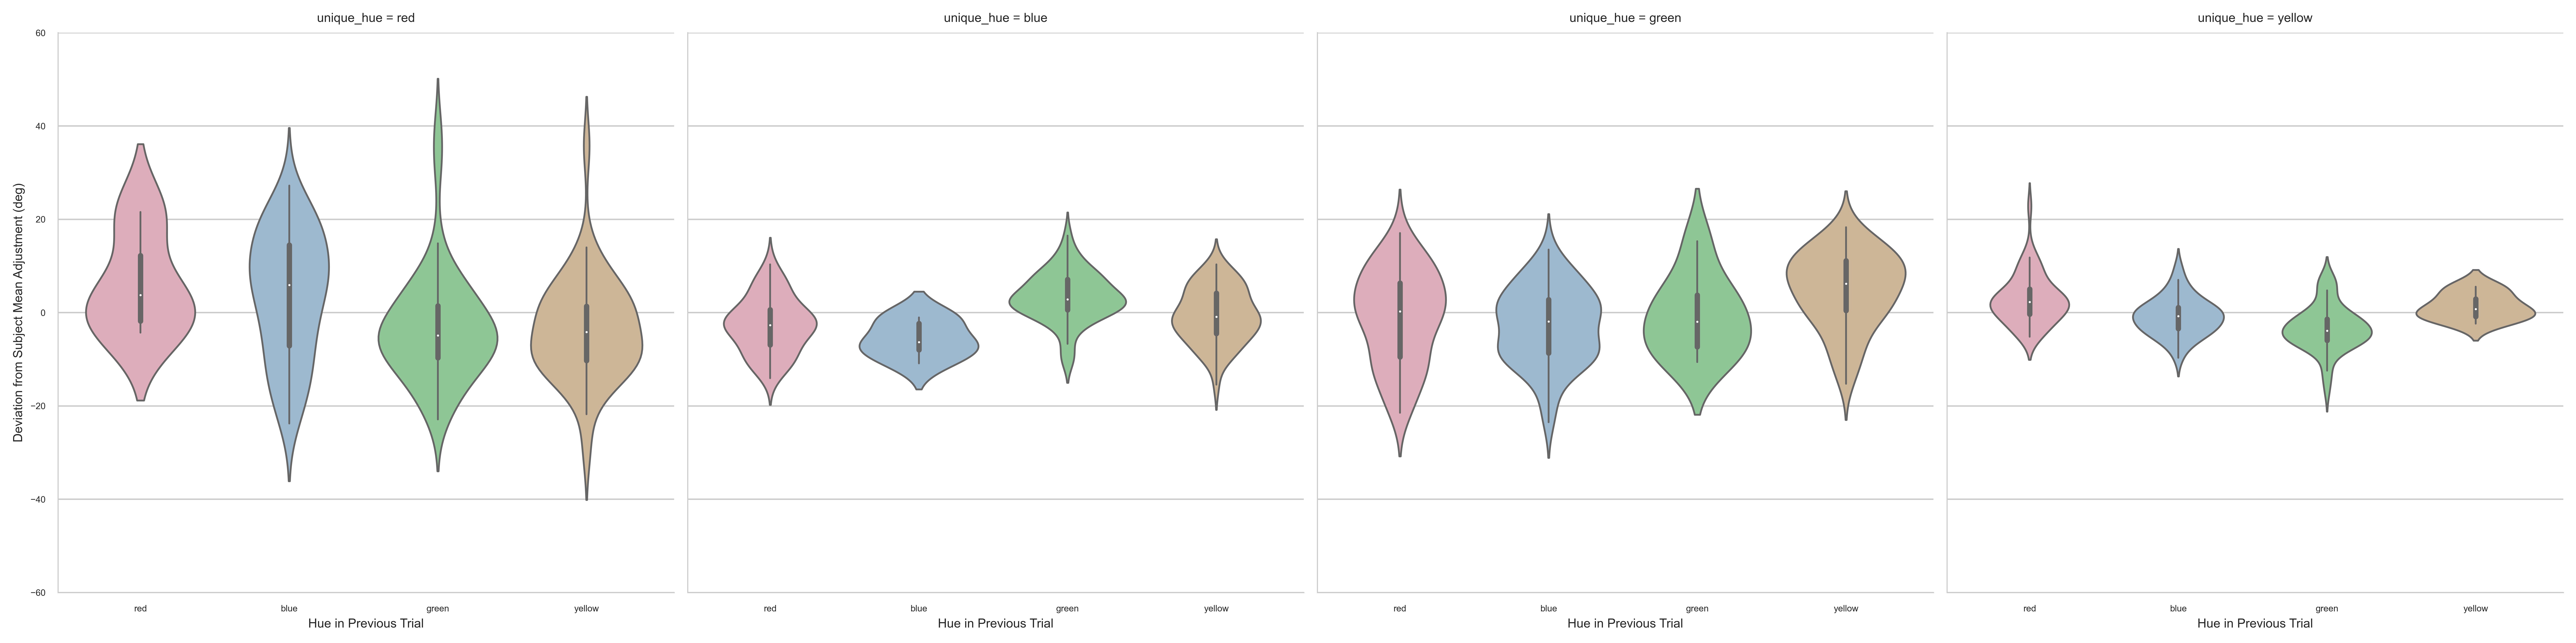

In [32]:
sns.set_style('whitegrid')
order = ['red', 'blue', 'green', 'yellow']
# sns.catplot(data=dat, x='previous_hue', y='deviation', row='crosstalk',  col='unique_hue', sharey=False, palette=palette, kind='violin', ci=68)
g = sns.catplot(data=dat, x='previous_hue', y='deviation', col='unique_hue', order=order, col_order=order, 
                sharey=True, palette=palette, kind='violin')
g.set(xlabel='Hue in Previous Trial', ylabel='Deviation from Subject Mean Adjustment (deg)')

# plt.savefig('data_analysis/figures/unique_hues/crosstalk_deviation_by_sub.pdf')
# plt.savefig('data_analysis/figures/unique_hues/all_trials_deviation.pdf')
plt.plot() 

In [34]:
sns.set_style('whitegrid')
order = ['red', 'blue', 'green', 'yellow']
# sns.catplot(data=dat, x='previous_hue', y='deviation', row='crosstalk',  col='unique_hue', sharey=False, palette=palette, kind='violin')
g = sns.catplot(data=dat, x='previous_hue', y='z-score', row='sub', col='unique_hue', order=order, col_order=order, 
                sharey=True, palette=palette, kind='violin')
            
g.set(xlabel='Hue in Previous Trial', ylabel='z-score')

# plt.savefig('data_analysis/figures/unique_hues/crosstalk_zscore_by_sub.pdf')
# plt.savefig('data_analysis/figures/unique_hues/all_trials_zscore.pdf')
# plt.savefig('data_analysis/figures/unique_hues/all_trials_by_sub.pdf')

plt.plot()


[]

In [35]:
stim = ['r', 'b', 'g', 'y']
n_rep = 5
n_ses = 6
import itertools
all_section = np.array(list(itertools.permutations(stim)))

In [36]:
seq = np.array([])
for i_ses in range(n_ses):
    rng = np.random.default_rng()
    seq = np.append(seq, rng.choice(all_section, 1, replace=False)[0])

    for i_rep in range(n_rep - 1):
        start_with = seq[-1]
        sel = [s[0] == start_with for s in all_section]

        next_sections = np.array(all_section)[sel]
        rng = np.random.default_rng()
        next_seq = rng.choice(next_sections, 1, replace=False)[0]
        seq = np.append(seq, next_seq)
    

In [37]:
df = pd.DataFrame({"session":np.repeat(np.arange(n_ses), 4 * n_rep), "trial": np.arange(len(seq)), "hue": seq})
df['previous_hue'] = df.groupby('session')['hue'].shift(periods=1)

df.head()

session  trial hue previous_hue
0        0      0   b          NaN
1        0      1   r            b
2        0      2   y            r
3        0      3   g            y
4        0      4   g            g

In [202]:
pd.pivot_table(data=df, index='hue', columns='previous_hue', values='trial', aggfunc='count')

previous_hue   b   g  r  y
hue                       
b              5   7  9  6
g              6   8  6  9
r              5  10  6  8
y             13   4  7  5

# Relate to prior peaks

In [2]:
def sine_fitter(x, amp, phi, off):
    """
    For iso-slant fit.
    :param x: Hue angle.
    :param amp: Amplitude.
    :param phi: Phase.
    :param off: Offset.
    :return: Sine value.
    """
    return amp * np.sin(x + phi) + off

In [23]:
from scipy import optimize
model_path = 'data_analysis/model_estimates_v2'
prior_peak_locs = pd.read_csv(f"{model_path}/gauss_prior_btrp100_peakloc.csv").query("sub !='sAVG'")
prior_dip_locs = pd.read_csv(f"{model_path}/gauss_prior_btrp100_diploc.csv").query("sub !='sAVG'")
sel_prior_peak_locs = prior_peak_locs.query("sub != 's4'")
sel_prior_dip_locs = prior_dip_locs.query("sub != 's4'")

isolum_phase_loc_list = []
unique_hue_loc_list = []
subs = ['s01', 's02', 's03', 's04', 's05', 's06']
for sub in subs:
    isolum_file = f"config/subjects/colorspace/10bit/colorspace_{sub}.json"
    with open(isolum_file, "r") as f:
        iso_slant = json.loads(json.load(f)['iso_slant'])
    params, pcov = optimize.curve_fit(sine_fitter, iso_slant['xdata'],  iso_slant['ydata'])
    phase = params[1]*180/np.pi
    if params[0] > 0:
        x_peak = np.pi * .5 - params[1]
    else:
        x_peak = np.pi * 1.5 - params[1]
    phase_std = (np.sqrt(np.diag(pcov)))[1] * 180/np.pi
    isolum_phase_loc_list.append(pd.DataFrame([{"sub": sub, "peak": x_peak*180/np.pi, "phase": phase, "phase_std": phase_std}]))
    if sub != 's04':  # s04 not included yet
        unique_hue_loc_list.append(pd.read_csv(f'data_analysis/unique_hues/{sub}_unique_hues.csv'))

isolum_phase_loc = pd.concat(isolum_phase_loc_list)
unique_hue_loc = pd.concat(unique_hue_loc_list)

In [22]:
prior_peak_locs

sub  circmean   circstd  Hue Angle mean  Hue Angle std        se
0  s1  2.247812  0.162968      128.790115       9.337381  0.016297
1  s2  0.473252  0.060151       27.115327       3.446411  0.006015
2  s3  1.458385  0.071045       83.559289       4.070599  0.007105
3  s4  1.113700  0.435364       63.810310      24.944547  0.043536
4  s5  1.736010  0.149840       99.466062       8.585188  0.014984
5  s6  0.130716  0.829329        7.489499      47.517033  0.082933

In [17]:
print(f"peak loc mean: {stats.circmean(prior_peak_locs['Hue Angle mean']/180*np.pi)/ np.pi*180}")
print(f"peak loc std: {stats.circstd(prior_peak_locs['Hue Angle mean']/180*np.pi)/ np.pi*180}")

peak loc mean: 103.8939003210917
peak loc std: 79.3494891997596


In [5]:
print(f"dip loc mean: {stats.circmean(prior_dip_locs['Hue Angle mean']/180*np.pi)/ np.pi*180}")
print(f"dip loc std: {stats.circstd(prior_dip_locs['Hue Angle mean']/180*np.pi)/ np.pi*180}")

dip loc mean: 248.81876254759638
dip loc std: 42.610865044901225


In [6]:
print(f"iso shift mean: {stats.circmean(isolum_phase_loc.phase/180*np.pi)/ np.pi*180}")
print(f"iso shift std: {stats.circstd(isolum_phase_loc.phase/180*np.pi)/ np.pi*180}")

shift mean: 87.89085138647673
shift std: 26.506614635991063


In [40]:
print(f"iso peak mean: {stats.circmean(isolum_phase_loc.peak/180*np.pi)/ np.pi*180}")
print(f"iso peak std: {stats.circstd(isolum_phase_loc.peak/180*np.pi)/ np.pi*180}")

iso peak mean: 182.10914861352327
iso peak std: 26.506614635991063


In [18]:
unique_hue_loc_intersub = unique_hue_loc.groupby('unique_hue')['circmean'].agg([stats.circmean, stats.circstd]) * 180/np.pi
unique_hue_loc_intersub

circmean   circstd
unique_hue                      
blue        127.583028  5.283638
green       228.943775  4.967951
red         350.915348  8.000934
yellow      289.700760  3.015784

In [19]:
unique_hue_loc_intersub.circstd.agg(['mean', 'std'])

mean    5.317076
std     2.051182
Name: circstd, dtype: float64

Text(0.5, 0, 'Isoluminant plane peak (deg)')

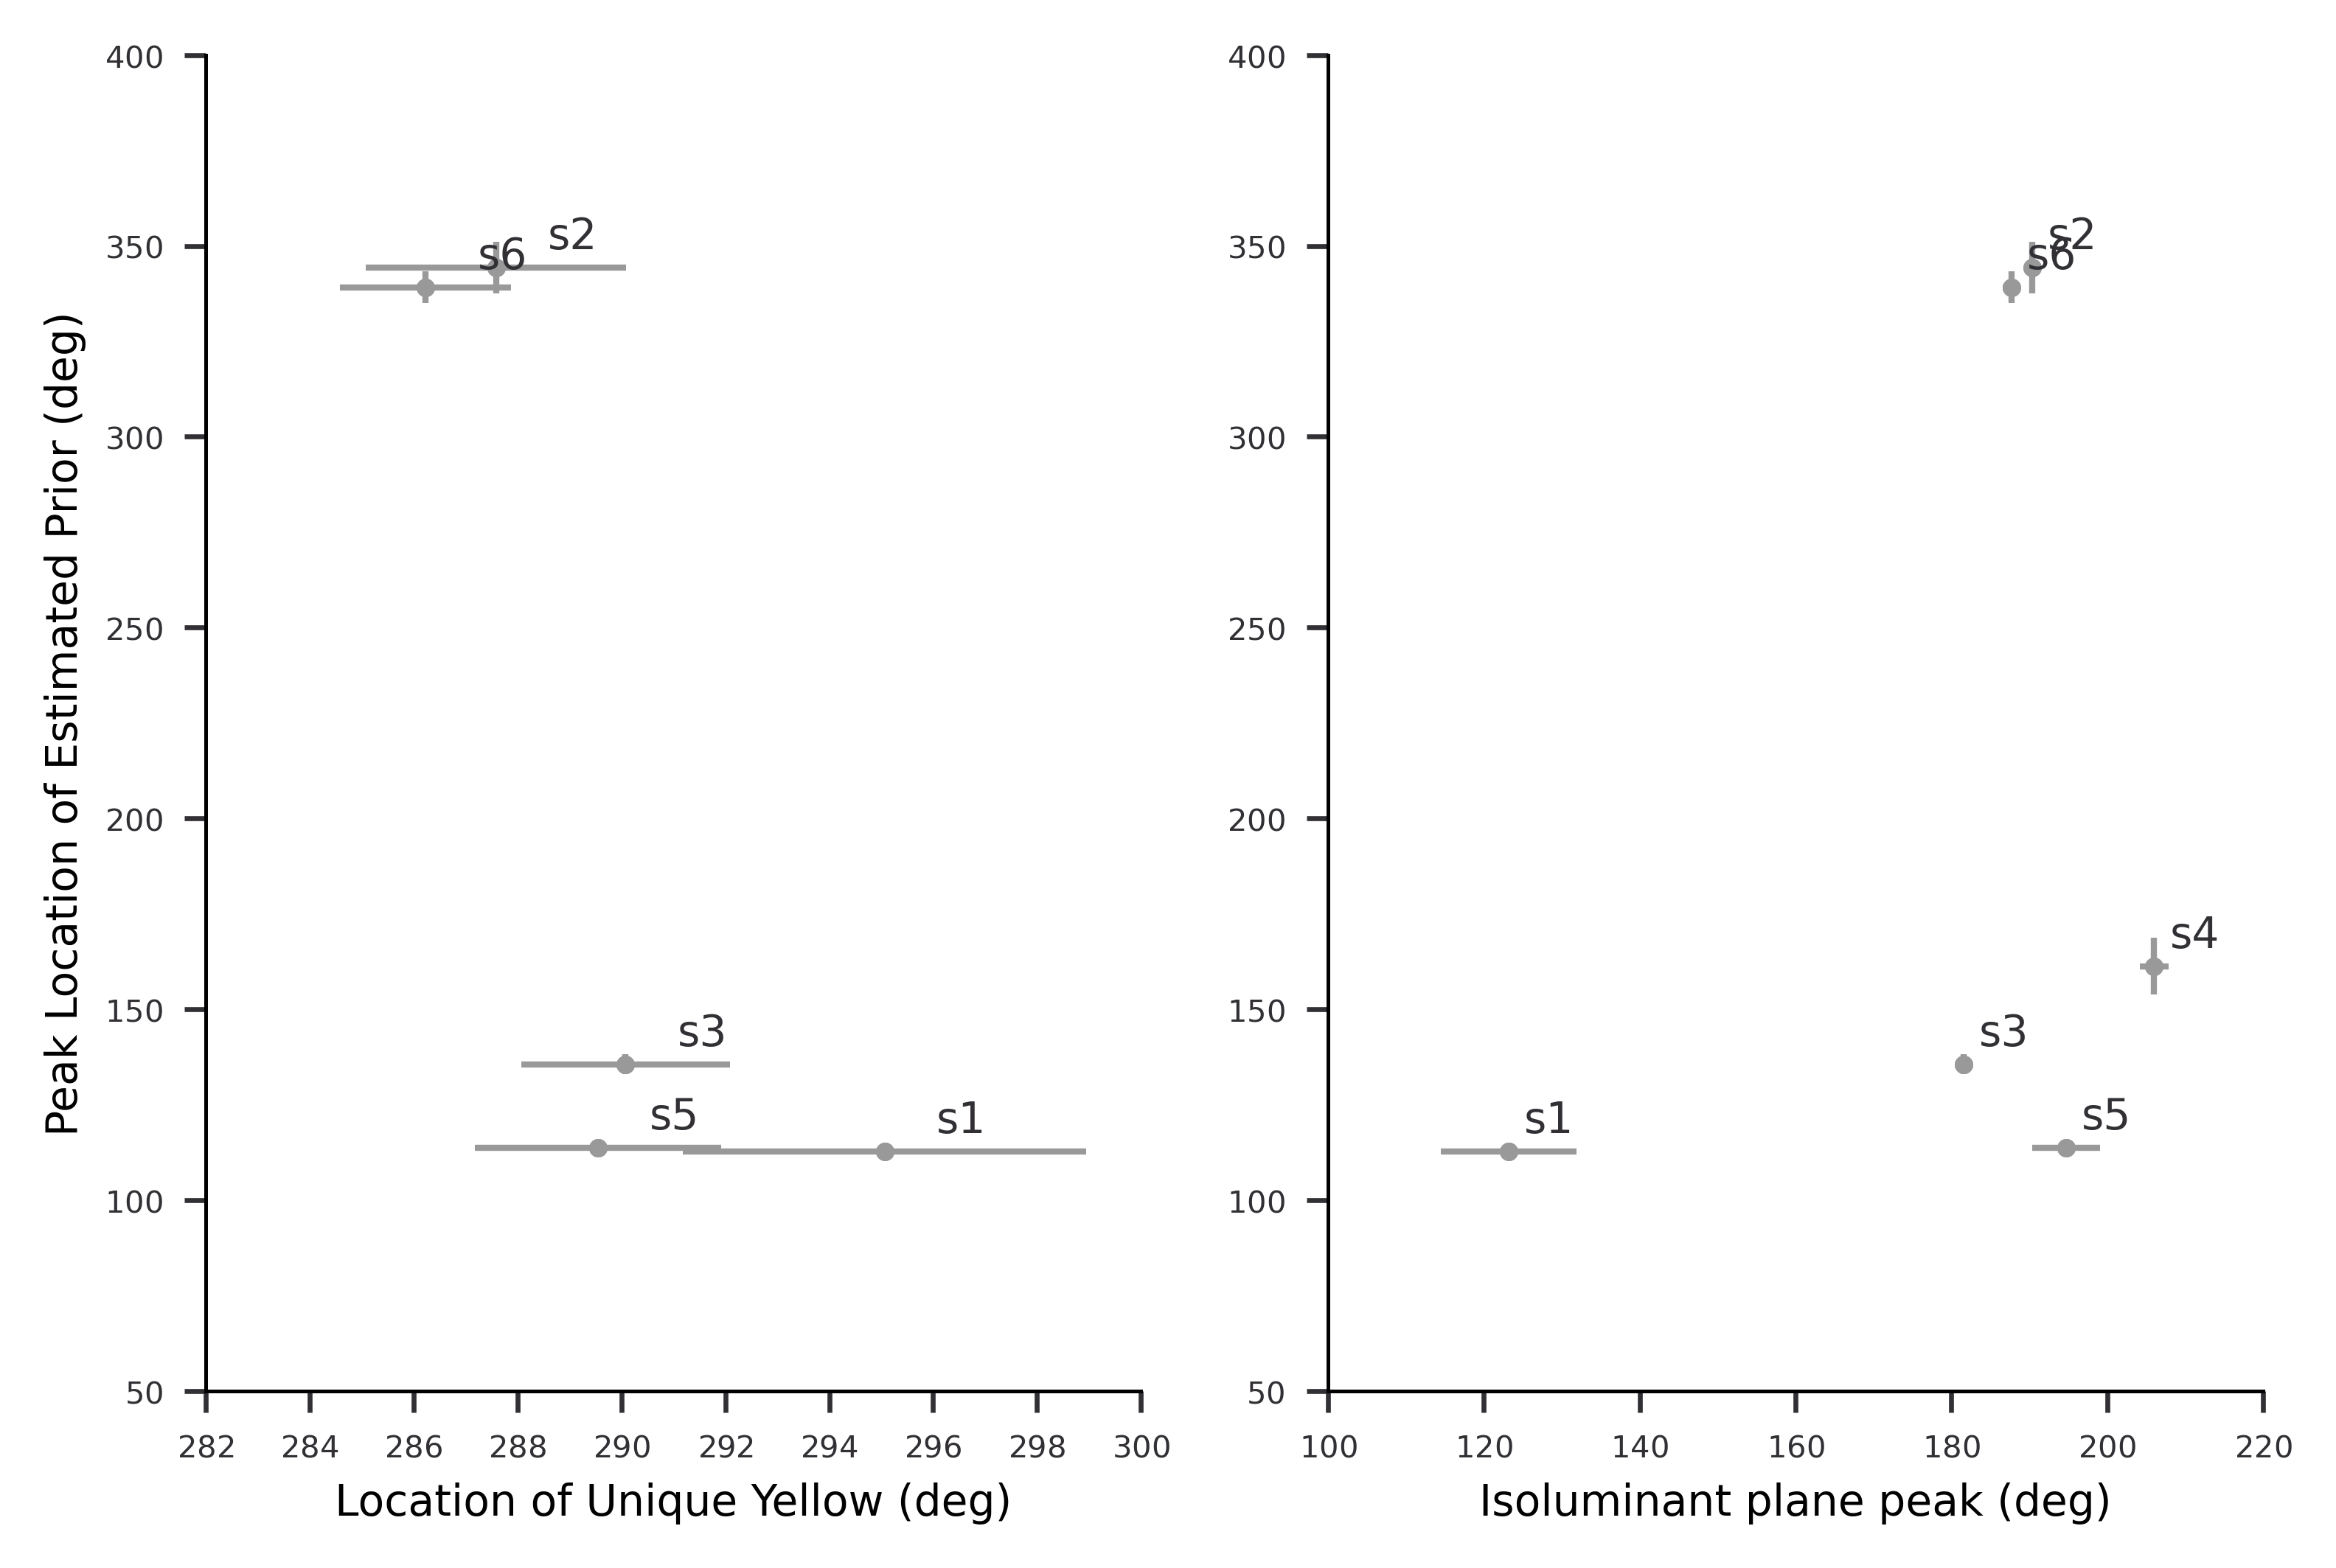

In [10]:
ppeak_mean = prior_peak_locs['Hue Angle mean'].values
ppeak_std = prior_peak_locs['Hue Angle std'].values
sel_ppeak_mean = sel_prior_peak_locs['Hue Angle mean'].values
sel_ppeak_std = sel_prior_peak_locs['Hue Angle std'].values

pdip_mean = prior_dip_locs['Hue Angle mean'].values
pdip_std = prior_dip_locs['Hue Angle std'].values
sel_pdip_mean = sel_prior_dip_locs['Hue Angle mean'].values
sel_pdip_std = sel_prior_dip_locs['Hue Angle std'].values

uhue_mean = unique_hue_loc[unique_hue_loc.unique_hue=='yellow']['circmean_deg'].values
uhue_std = unique_hue_loc[unique_hue_loc.unique_hue=='yellow']['circstd_deg'].values
iphase_mean = isolum_phase_loc['phase'].values
iphase_std = isolum_phase_loc['phase_std'].values

ipeak_mean = isolum_phase_loc['peak'].values
ipeak_std = isolum_phase_loc['phase_std'].values

fig, ax = plt.subplots(ncols=2)

# subplot 1 
ax[0].errorbar(uhue_mean,sel_ppeak_mean, 
            xerr=uhue_std/np.sqrt(len(subs)),
            fmt='o', label='unique_hue', color=[.6, .6, .6])
ax[0].errorbar(uhue_mean, sel_ppeak_mean, 
            yerr=sel_ppeak_std/np.sqrt(len(subs)),
            fmt='o', color=[.6, .6, .6])#, label='prior peak')


# subplot 2
# ax[1].scatter(iphase, ppeak_mean,
#             label='isolum_shift', marker='o', color=[.2, .2, .2], linewidth=0)
ax[1].errorbar(ipeak_mean, ppeak_mean, 
            xerr=iphase_std/np.sqrt(len(subs)),
            fmt='o', label='isolum_shift', color=[.6, .6, .6])
ax[1].errorbar(ipeak_mean, ppeak_mean,
            yerr=ppeak_std/np.sqrt(len(subs)),
            fmt='o', color=[.6, .6, .6])#, label='prior peak')


for idx, txt in enumerate(['s1', 's2', 's3', 's5', 's6']):
    ax[0].annotate(txt, (uhue_mean[idx]+1, sel_ppeak_mean[idx]+ 5))
for idx, txt in enumerate(['s1', 's2', 's3', 's4', 's5', 's6']):
    ax[1].annotate(txt, (ipeak_mean[idx]+2, ppeak_mean[idx] + 5))

# plt.legend()
ax[0].set_ylabel('Peak Location of Estimated Prior (deg)')
ax[0].set_xlabel('Location of Unique Yellow (deg)')
ax[1].set_xlabel('Isoluminant plane peak (deg)')

# ax[0].set_xlim([120, 135])
# ax[1].set_xlim([50, 100])


Text(0.5, 0, 'Isoluminant plane shift (deg)')

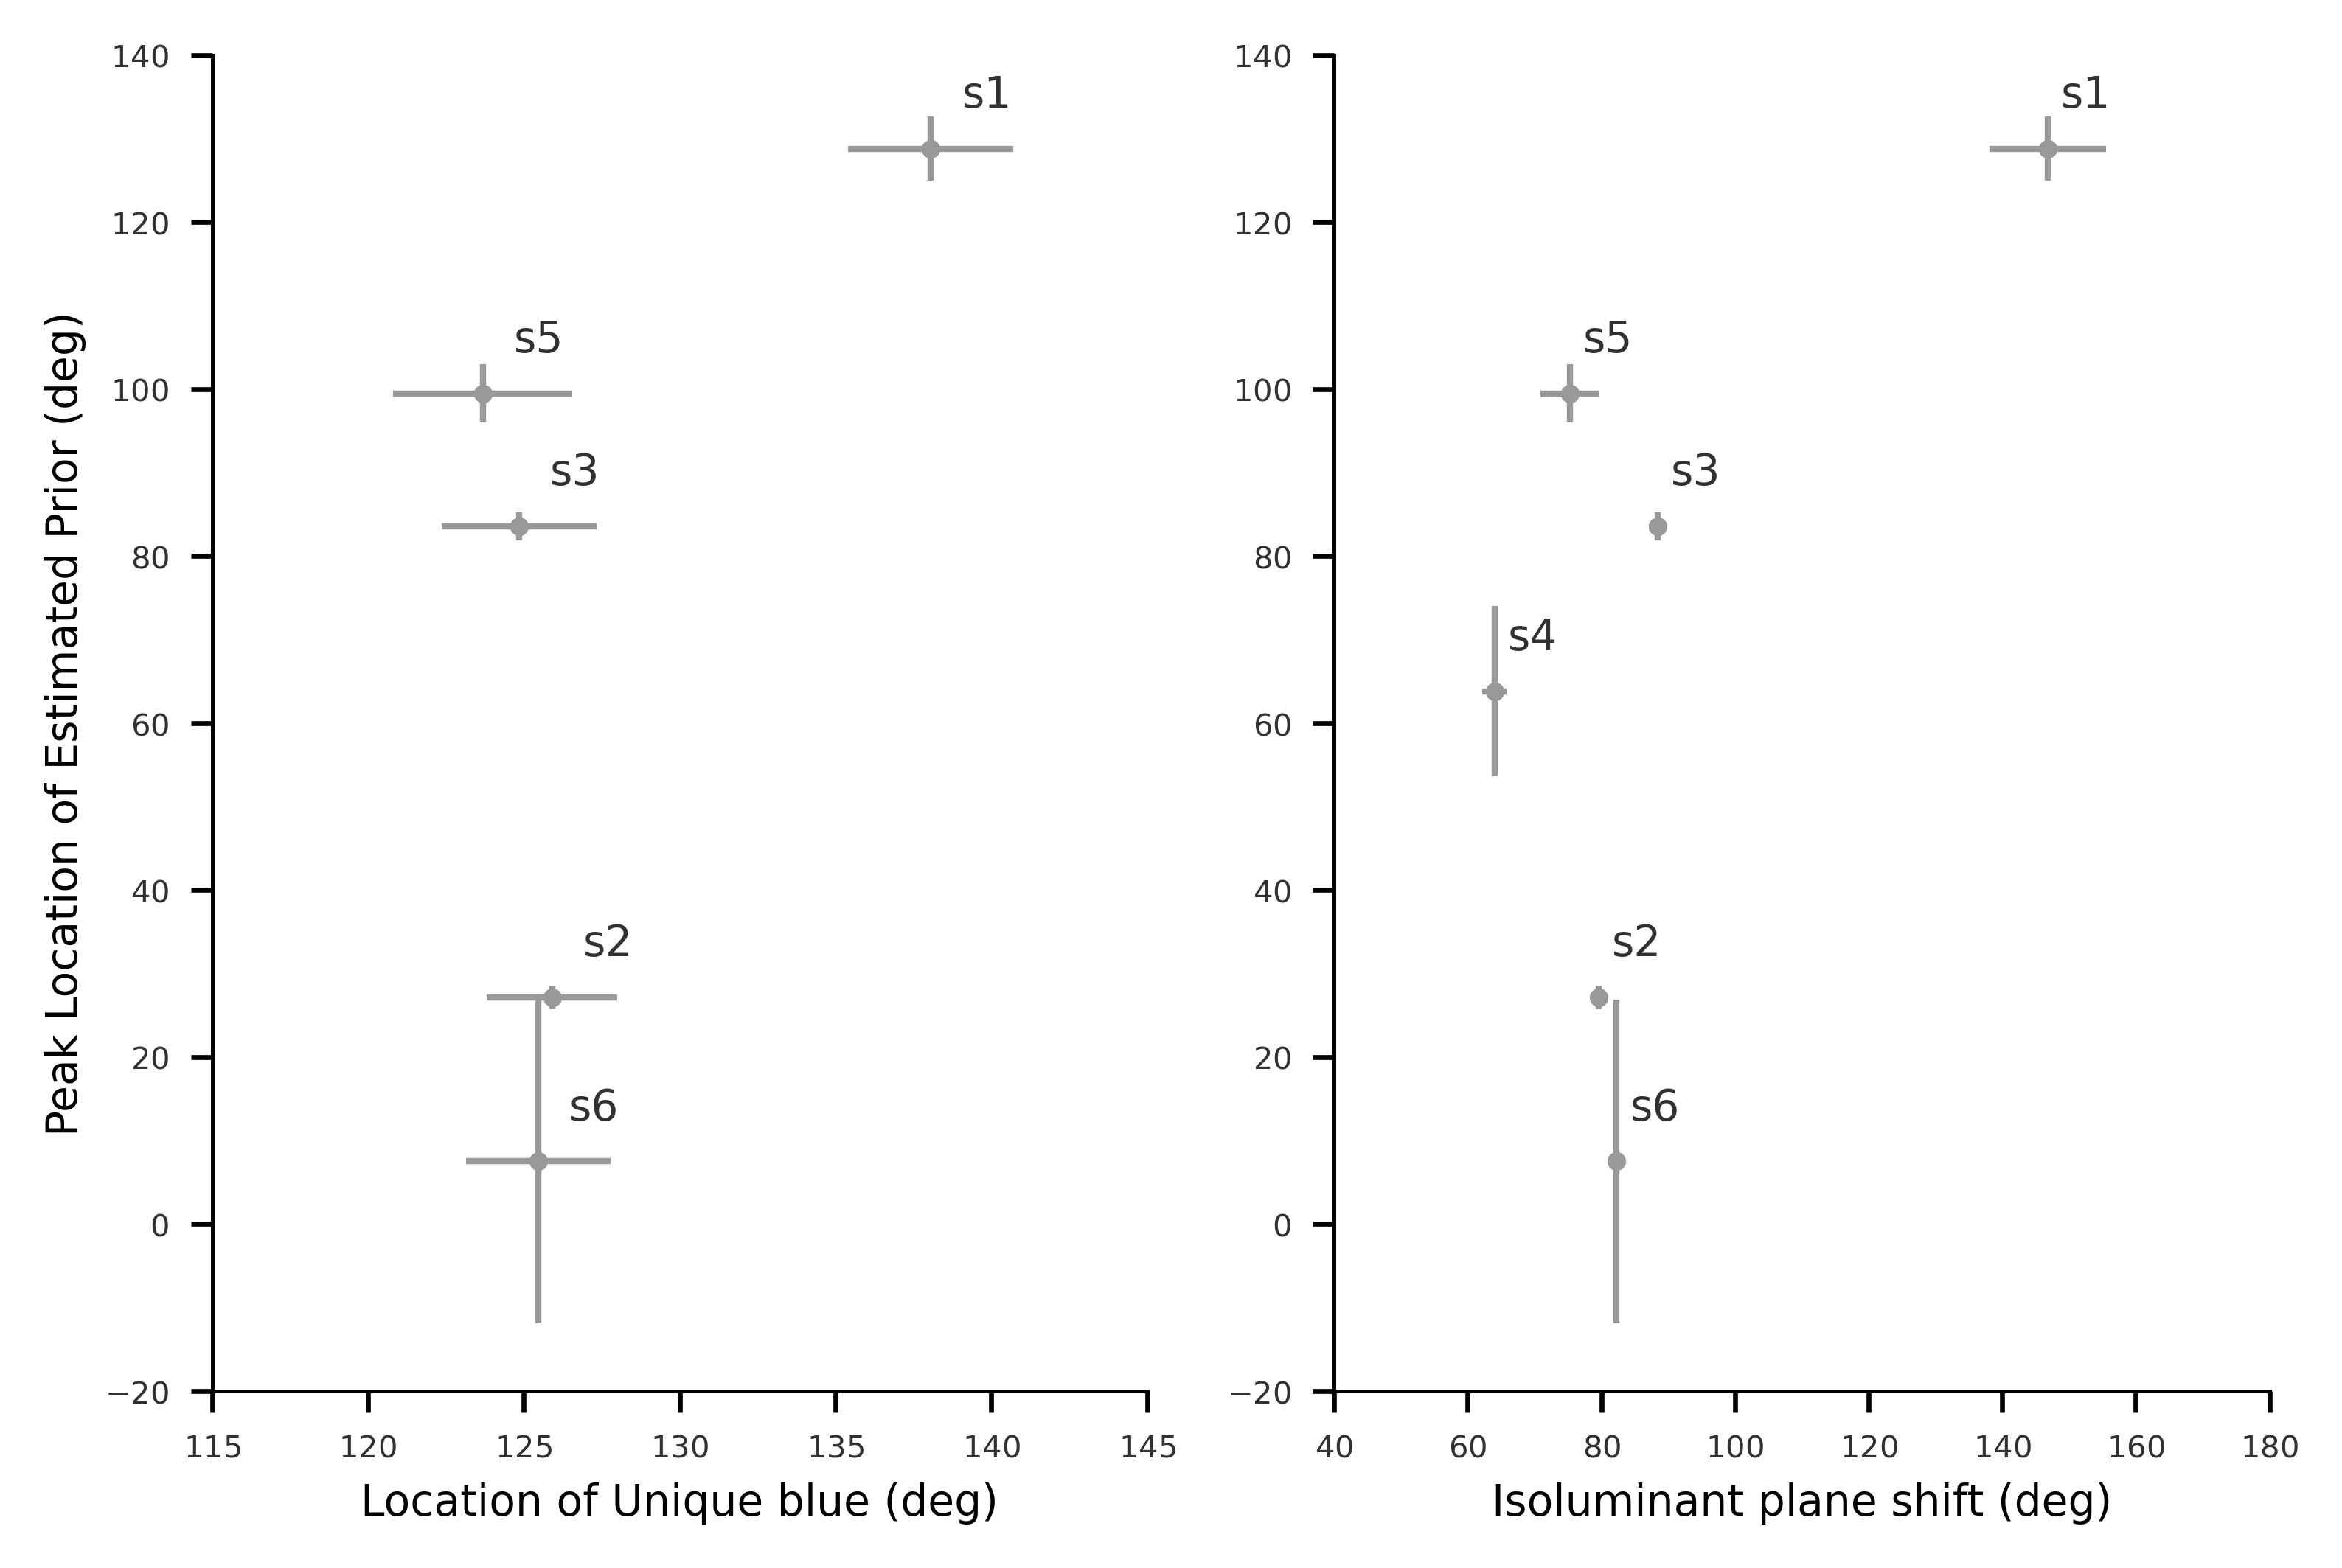

In [35]:
ppeak_mean = prior_peak_locs['Hue Angle mean'].values
ppeak_std = prior_peak_locs['Hue Angle std'].values
sel_ppeak_mean = sel_prior_peak_locs['Hue Angle mean'].values
sel_ppeak_std = sel_prior_peak_locs['Hue Angle std'].values

pdip_mean = prior_dip_locs['Hue Angle mean'].values
pdip_std = prior_dip_locs['Hue Angle std'].values
sel_pdip_mean = sel_prior_dip_locs['Hue Angle mean'].values
sel_pdip_std = sel_prior_dip_locs['Hue Angle std'].values

uhue_mean = unique_hue_loc[unique_hue_loc.unique_hue=='yellow']['circmean_deg'].values
uhue_std = unique_hue_loc[unique_hue_loc.unique_hue=='yellow']['circstd_deg'].values
iphase_mean = isolum_phase_loc['phase'].values
iphase_std = isolum_phase_loc['phase_std'].values

fig, ax = plt.subplots(ncols=2)

# subplot 1 
ax[0].errorbar(uhue_mean,sel_ppeak_mean, 
            xerr=uhue_std/np.sqrt(len(subs)),
            fmt='o', label='unique_hue', color=[.6, .6, .6])
ax[0].errorbar(uhue_mean, sel_ppeak_mean, 
            yerr=sel_ppeak_std/np.sqrt(len(subs)),
            fmt='o', color=[.6, .6, .6])#, label='prior peak')


# subplot 2
# ax[1].scatter(iphase, ppeak_mean,
#             label='isolum_shift', marker='o', color=[.2, .2, .2], linewidth=0)
ax[1].errorbar(iphase_mean, ppeak_mean, 
            xerr=iphase_std/np.sqrt(len(subs)),
            fmt='o', label='isolum_shift', color=[.6, .6, .6])
ax[1].errorbar(iphase_mean, ppeak_mean,
            yerr=ppeak_std/np.sqrt(len(subs)),
            fmt='o', color=[.6, .6, .6])#, label='prior peak')


for idx, txt in enumerate(['s1', 's2', 's3', 's5', 's6']):
    ax[0].annotate(txt, (uhue_mean[idx]+1, sel_ppeak_mean[idx]+ 5))
for idx, txt in enumerate(['s1', 's2', 's3', 's4', 's5', 's6']):
    ax[1].annotate(txt, (iphase_mean[idx]+2, ppeak_mean[idx] + 5))

# plt.legend()
ax[0].set_ylabel('Peak Location of Estimated Prior (deg)')
ax[0].set_xlabel('Location of Unique Yellow (deg)')
ax[1].set_xlabel('Isoluminant plane shift (deg)')

# ax[0].set_xlim([120, 135])
# ax[1].set_xlim([50, 100])


In [25]:
from scipy.stats.stats import pearsonr
print("correlation between yellow peak location and prior peak location:")
pearsonr(sel_ppeak_mean, unique_hue_loc[unique_hue_loc.unique_hue=='yellow']['circmean_deg'])

correlation between yellow peak location and prior peak location:


(-0.7739937366237016, 0.12451286789295861)

In [26]:
print("correlation between blue peak location and prior peak location:")
pearsonr(sel_ppeak_mean, unique_hue_loc[unique_hue_loc.unique_hue=='blue']['circmean_deg'])

correlation between blue peak location and prior peak location:


(-0.32741443384406266, 0.5906958201533301)

In [27]:
print("correlation between red peak location and prior peak location:")
red_loc = unique_hue_loc[unique_hue_loc.unique_hue=='red']['circmean_deg'].apply(lambda x: x+360 if x < 40 else x)
pearsonr(sel_ppeak_mean, red_loc)

correlation between red peak location and prior peak location:


(-0.09156084027213258, 0.8835842105219657)

In [28]:
print("correlation between green peak location and prior peak location:")
pearsonr(sel_ppeak_mean, unique_hue_loc[unique_hue_loc.unique_hue=='green']['circmean_deg'])

correlation between green peak location and prior peak location:


(-0.428390249603885, 0.4717320802408073)

In [45]:
pearsonr(ppeak_mean, iphase_mean)

(0.5973584237895394, 0.2105421840780701)

(0.9853970253493525, 0.0021136947352597985)

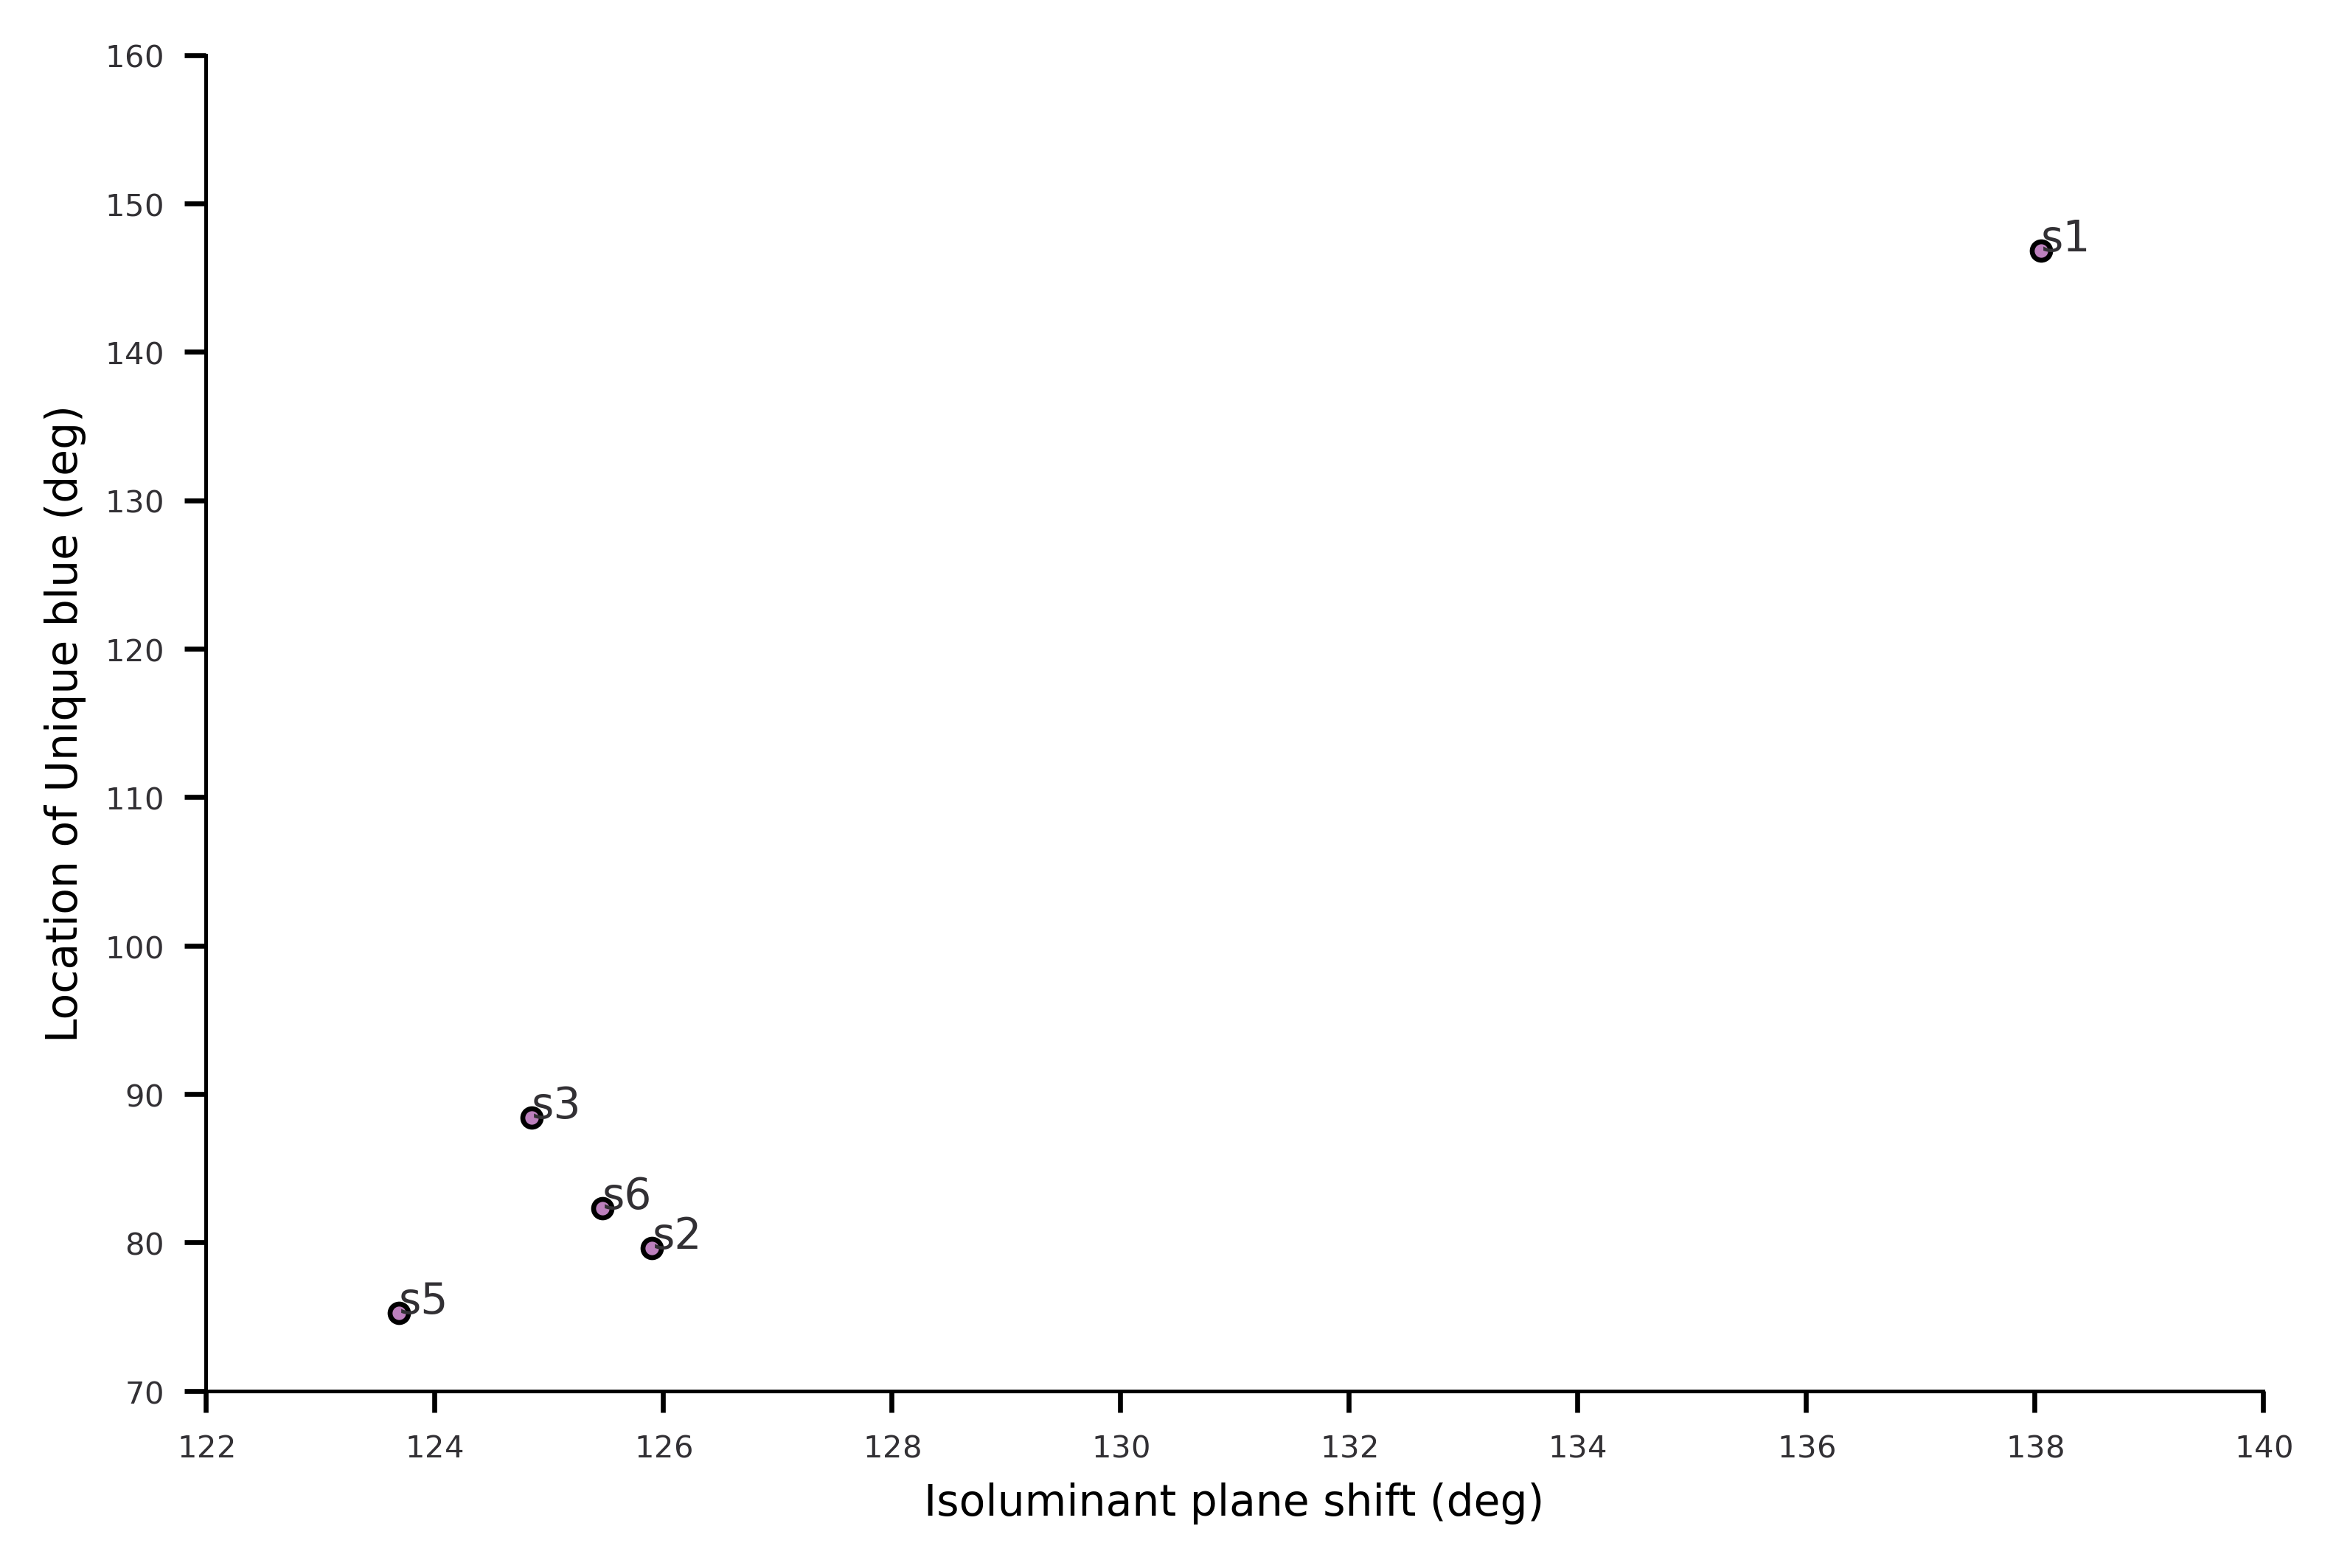

In [49]:
fig, ax = plt.subplots()
ax.scatter(unique_hue_loc[unique_hue_loc.unique_hue=='blue']['circmean_deg'], 
            isolum_phase_loc[isolum_phase_loc['sub']!='s04'].phase)
ax.set_ylabel("Location of Unique blue (deg)")
ax.set_xlabel("Isoluminant plane shift (deg)")


for idx, txt in enumerate(['s1', 's2', 's3', 's5', 's6']):
    ax.annotate(txt, (unique_hue_loc[unique_hue_loc.unique_hue=='blue']['circmean_deg'].values[idx], 
    isolum_phase_loc[isolum_phase_loc['sub']!='s04'].phase.values[idx] ))

pearsonr(unique_hue_loc[unique_hue_loc.unique_hue=='blue']['circmean_deg'], 
        isolum_phase_loc[isolum_phase_loc['sub']!='s04'].phase)